# Importing Libraries

In [59]:
import numpy as np
import pandas as pd
import pymysql,pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings. simplefilter('ignore')
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,StratifiedKFold
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from scipy.stats import f_oneway,ttest_ind
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import FunctionTransformer,StandardScaler
import tkinter as tk

# Importing data through pandas

In [2]:
df = pd.read_csv('TelcomCustomer-Churn.csv')
df1 = pd.read_csv('TelcomCustomer-Churn_1.csv')
df2 = pd.read_csv('TelcomCustomer-Churn_2.csv')
df1_new = pd.concat([df1,df2],axis=1)
df1_new1 = pd.concat([df1_new,df],axis=0)

# Importing data from MYSQL server

In [3]:
db = pymysql.connect(host = "localhost",user = "root",password = "Qwerty1113#",database = "project_schema" )
cursor = db.cursor()

def import_data(x):
    cursor.execute(f"SELECT * FROM project_schema.{x};")
    data = cursor.fetchall()
    return pd.DataFrame(data,columns=[a[0] for a in cursor.description])

In [4]:
d = import_data('telcomcustomer_churn')
d1 = import_data('telcomcustomer_churn_1')
d2 = import_data('telcomcustomer_churn_2')

# Explore shape and size

In [7]:
def shape_size(x):
    shape = x.shape
    size = x.size
    return (f"The shape is {shape} and size is {size}")

In [8]:
shape_size(d)

'The shape is (7043, 21) and size is 147903'

In [9]:
shape_size(d1)

'The shape is (7043, 10) and size is 70430'

In [10]:
shape_size(d2)

'The shape is (7043, 11) and size is 77473'

# Merge all datasets onto one and explore final shape and size.

In [11]:
data = pd.concat([d1,d2],axis=1)

In [12]:
data1 = pd.concat([data,d],axis=0)

In [13]:
shape_size(data1)
#exploring the final shape and size

'The shape is (14086, 21) and size is 295806'

In [14]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14086 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        14086 non-null  object 
 1   gender            14086 non-null  object 
 2   SeniorCitizen     14086 non-null  int64  
 3   Partner           14086 non-null  object 
 4   Dependents        14086 non-null  object 
 5   tenure            14086 non-null  int64  
 6   PhoneService      14086 non-null  object 
 7   MultipleLines     14086 non-null  object 
 8   InternetService   14086 non-null  object 
 9   OnlineSecurity    14086 non-null  object 
 10  OnlineBackup      14086 non-null  object 
 11  DeviceProtection  14086 non-null  object 
 12  TechSupport       14086 non-null  object 
 13  StreamingTV       14086 non-null  object 
 14  StreamingMovies   14086 non-null  object 
 15  Contract          14086 non-null  object 
 16  PaperlessBilling  14086 non-null  object 

# Missing value treatment

In [15]:
df1_new1.isnull().sum()
#Here we take the normal pandas uploaded file since SQL does not allow null values to be added. The null values 
#were added as NA so one can filter NA under total charges and remove those rows, provided missing value treatment
#needs to be done in SQL loaded dataframe

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        22
Churn                0
dtype: int64

In [16]:
f = round(22/14086*100,2)
print(f"The null/missing values in the data is {f}%, so we remove them.")

The null/missing values in the data is 0.16%, so we remove them.


In [17]:
dd = df1_new1.dropna(axis=0)

In [18]:
dd.isnull().sum()
#All null values are removed

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Convert categorical attributes to continuous using relevant functional knowledge

In [19]:
df1_new1['gender'] = pd.get_dummies(df1_new1['gender'],drop_first=True)
df1_new1['SeniorCitizen']= pd.get_dummies(df1_new1['SeniorCitizen'],drop_first=True)
df1_new1['Partner'] = pd.get_dummies(df1_new1['Partner'],drop_first=True)
df1_new1['Dependents'] = pd.get_dummies(df1_new1['Dependents'],drop_first=True)
df1_new1['PhoneService'] = pd.get_dummies(df1_new1['PhoneService'],drop_first=True)
df1_new1['MultipleLines'] = df1_new1['MultipleLines'].replace({'No phone service':0,'No':1,'Yes':2})
#It's simple — fiber is fast, while DSL uses copper phone lines to transmit data, fiber uses ultra-thin glass strands that carry light instead of electricity. Since light can travel very quickly through the fiber-optic cables, fiber connection can see gigabit speeds 100x faster than DSL.
df1_new1['InternetService'] = df1_new1['InternetService'].replace({'DSL':1,'Fiber optic':2,'No':0})
df1_new1['OnlineSecurity'] = df1_new1['OnlineSecurity'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['OnlineBackup'] = df1_new1['OnlineBackup'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['DeviceProtection'] = df1_new1['DeviceProtection'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['TechSupport'] = df1_new1['TechSupport'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['StreamingTV'] = df1_new1['StreamingTV'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['StreamingMovies'] = df1_new1['StreamingMovies'].replace({'No internet service':0,'No':1,'Yes':2})
df1_new1['Contract'] = df1_new1['Contract'].replace({'Two year':2,'One year':1,'Month-to-month':0})
df1_new1['PaperlessBilling'] = pd.get_dummies(df1_new1['PaperlessBilling'],drop_first=True)
df1_new1['PaymentMethod'] = df1_new1['PaymentMethod'].replace({'Electronic check':2,'Mailed check':0,'Bank transfer (automatic)':2,'Credit card (automatic)':1})
df1_new1['Churn'] = pd.get_dummies(df1_new1['Churn'],drop_first=True)

In [20]:
ab = df1_new1
# This is to use in the future while segregating predictors and features

# Drop attribute/s if required using relevant functional knowledge

#### • customerID : This is a unique identification number given to every Customer, we know that this is a nominal data. With increase in customer ID we wont find any improvement in churn.


In [21]:
df1_new1.drop(['customerID'],axis=1,inplace=True)

In [22]:
df1_new1

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,1,1,2,2,1,1,1,1,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,2,1,1,1,1,1,1,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,1,2,1,2,2,2,2,1,1,0,84.80,1990.50,0
7039,0,0,1,1,72,1,2,2,1,2,2,1,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,1,2,1,1,1,1,1,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,2,1,1,1,1,1,1,0,1,0,74.40,306.60,1


# • Automate all the above steps

In [23]:
db = pymysql.connect(host = "localhost",user = "root",password = "Qwerty1113#",database = "project_schema" )
cursor = db.cursor()

#Function to import data from SQL DB
def import_data(x):
    cursor.execute(f"SELECT * FROM project_schema.{x};")
    data = cursor.fetchall()
    return pd.DataFrame(data,columns=[a[0] for a in cursor.description])

#Function to explain the shape and size
def shape_size(x):
    shape = x.shape
    size = x.size
    return (f"The shape is {shape} and size is {size}")

#Function to automate all the process except label encoding. The categorical variables that take labels are manually encoded
#as per their meaning.
def initiate_func():
    """This is just to initiate the action. We automate all the way till it is a dummy variable but post that we 
    label encode them based on every category."""
    #Step1 - calling SQL
    d0 = import_data('telcomcustomer_churn')
    d1 = import_data('telcomcustomer_churn_1')
    d2 = import_data('telcomcustomer_churn_2')
    #Step2 - Merging DataFrames
    df1 = pd.concat([d1,d2],axis=1)
    df1 = pd.concat([df1,d0],axis=0)
    #Step3 - Finding Shape and size
    print(shape_size(df1))
    print("")
    #Step4 - Removing blank cells
    print(df1.isnull().sum())
    f = round(22/14086*100,2)
    print("")
    print(f"The null/missing values in the data is {f}%, so we remove them.")
    df1.dropna(axis=0,inplace=True)
    #Step5 - Creating dummy variables for any categorical columns that have only 2 binary type data.
    for n in df1.columns:
        if df1[n].dtype=='object':
            if df1[n].nunique() == 2:
                df1[n] = pd.get_dummies(df1[n],drop_first=True)
            else:
                pass
        else:
            pass
    #Step6 - Manually creating labels using Replace method
    df1['MultipleLines'] = df1['MultipleLines'].replace({'No phone service':0,'No':1,'Yes':2})
    #It's simple — fiber is fast, while DSL uses copper phone lines to transmit data, fiber uses ultra-thin glass strands that carry light instead of electricity. Since light can travel very quickly through the fiber-optic cables, fiber connection can see gigabit speeds 100x faster than DSL.
    df1['InternetService'] = df1['InternetService'].replace({'DSL':1,'Fiber optic':2,'No':0})
    df1['OnlineSecurity'] = df1['OnlineSecurity'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['OnlineBackup'] = df1['OnlineBackup'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['DeviceProtection'] = df1['DeviceProtection'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['TechSupport'] = df1['TechSupport'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['StreamingTV'] = df1['StreamingTV'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['StreamingMovies'] = df1['StreamingMovies'].replace({'No internet service':0,'No':1,'Yes':2})
    df1['Contract'] = df1['Contract'].replace({'Two year':2,'One year':1,'Month-to-month':0})
    df1['PaymentMethod'] = df1['PaymentMethod'].replace({'Electronic check':2,'Mailed check':0,'Bank transfer (automatic)':2,'Credit card (automatic)':1})
    df1.drop(['gender','customerID'],axis=1,inplace=True)
    return df1

In [24]:
a = initiate_func()

The shape is (14086, 21) and size is 295806

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The null/missing values in the data is 0.16%, so we remove them.


In [25]:
def dropnull(x):
    x = x.dropna(axis=0)
    return x

def drop_cust(x):
    x = x.drop('customerID',axis=0)
    return x
def categorise(df1_new1):
    df1_new1['gender'] = pd.get_dummies(df1_new1['gender'],drop_first=True)
    df1_new1['SeniorCitizen']= pd.get_dummies(df1_new1['SeniorCitizen'],drop_first=True)
    df1_new1['Partner'] = pd.get_dummies(df1_new1['Partner'],drop_first=True)
    df1_new1['Dependents'] = pd.get_dummies(df1_new1['Dependents'],drop_first=True)
    df1_new1['PhoneService'] = pd.get_dummies(df1_new1['PhoneService'],drop_first=True)
    df1_new1['MultipleLines'] = df1_new1['MultipleLines'].replace({'No phone service':0,'No':1,'Yes':2})
    #It's simple — fiber is fast, while DSL uses copper phone lines to transmit data, fiber uses ultra-thin glass strands that carry light instead of electricity. Since light can travel very quickly through the fiber-optic cables, fiber connection can see gigabit speeds 100x faster than DSL.
    df1_new1['InternetService'] = df1_new1['InternetService'].replace({'DSL':1,'Fiber optic':2,'No':0})
    df1_new1['OnlineSecurity'] = df1_new1['OnlineSecurity'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['OnlineBackup'] = df1_new1['OnlineBackup'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['DeviceProtection'] = df1_new1['DeviceProtection'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['TechSupport'] = df1_new1['TechSupport'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['StreamingTV'] = df1_new1['StreamingTV'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['StreamingMovies'] = df1_new1['StreamingMovies'].replace({'No internet service':0,'No':1,'Yes':2})
    df1_new1['Contract'] = df1_new1['Contract'].replace({'Two year':2,'One year':1,'Month-to-month':0})
    df1_new1['PaperlessBilling'] = pd.get_dummies(df1_new1['PaperlessBilling'],drop_first=True)
    df1_new1['PaymentMethod'] = df1_new1['PaymentMethod'].replace({'Electronic check':2,'Mailed check':0,'Bank transfer (automatic)':2,'Credit card (automatic)':1})
    df1_new1['Churn'] = pd.get_dummies(df1_new1['Churn'],drop_first=True)
    return df1_new1

#Can be used in future

# 3. Data analysis & visualisation:

### Perform detailed statistical analysis on the data

In [26]:
df1_new1.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [27]:
df1_new1.info()
#We notice only Monthly,Total charges and Tenure  to be continuous data and the rest all are categorical

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14086 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14086 non-null  uint8  
 1   SeniorCitizen     14086 non-null  uint8  
 2   Partner           14086 non-null  uint8  
 3   Dependents        14086 non-null  uint8  
 4   tenure            14086 non-null  int64  
 5   PhoneService      14086 non-null  uint8  
 6   MultipleLines     14086 non-null  int64  
 7   InternetService   14086 non-null  int64  
 8   OnlineSecurity    14086 non-null  int64  
 9   OnlineBackup      14086 non-null  int64  
 10  DeviceProtection  14086 non-null  int64  
 11  TechSupport       14086 non-null  int64  
 12  StreamingTV       14086 non-null  int64  
 13  StreamingMovies   14086 non-null  int64  
 14  Contract          14086 non-null  int64  
 15  PaperlessBilling  14086 non-null  uint8  
 16  PaymentMethod     14086 non-null  int64  

In [28]:
df1_new1.describe()[['tenure','TotalCharges','MonthlyCharges']].T
# Taking 5 point summary of only Monthly,Total charges and Tenure as they are continuous
# We see that 75% and max of Total charges is way too elongated, this shows there are chances of it having ouliers

,count,mean,std,min,25%,50%,75%,max
tenure,14086.0,32.371149,24.558609,0.00,9.00,29.000,55.0000,72.00
TotalCharges,14064.0,2283.300441,2266.690767,18.80,401.45,1397.475,3794.7375,8684.80
MonthlyCharges,14086.0,64.761692,30.088979,18.25,35.50,70.350,89.8500,118.75


In [29]:
cont_col = ['tenure','TotalCharges','MonthlyCharges']

def plot_continuous():
    for a in cont_col:
        sns.set(color_codes=True)
        plt.figure(figsize=(12,8))
        sns.distplot(df1_new1[a])

# Here we will see the skewness of the data in total charges, monthly charges and tenure being multimodal,

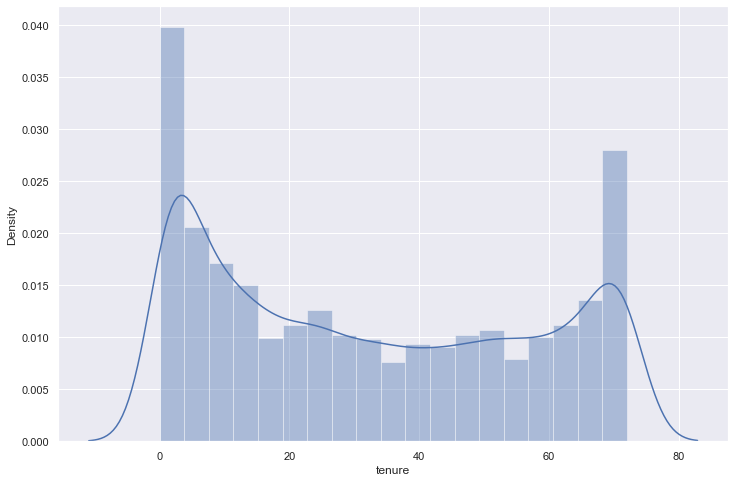

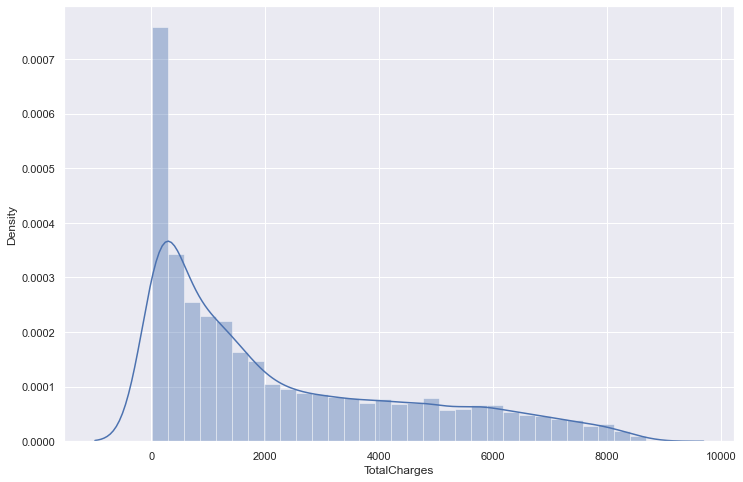

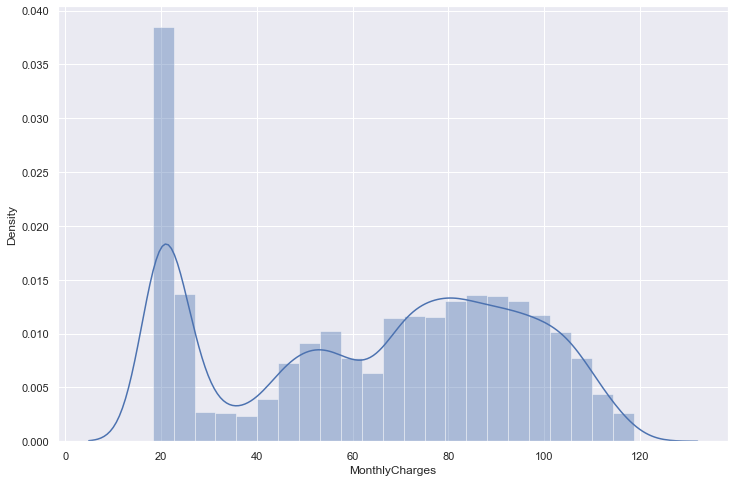

In [30]:
plot_continuous()

## Since there are 14000 plus rows, we check for the duplicates.
#### - we notice that 14,086 is double of 7043
#### - The concatenation of Churn1 and Churn2 file is same as Churn. So, we neglect this Churn1 and Churn2 and take only Churn data
#### - So, we will neglect one of the dataframes and move on with non duplicated items.

In [31]:
df1_new1.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038     True
7039     True
7040     True
7041     True
7042     True
Length: 14086, dtype: bool

In [32]:
n = data1['customerID'].value_counts()
a = np.array(n)
dups = []
def duplicate_finder():
    for n in a:
        if n == 1:
            dups.append(n)
        else:
            pass
    if not dups:
        print("All the contents are duplicated ")
    else:
        print("Few items in the list dups are duplicated")

#We take data1 that is taken from the source of SQL, it contains customer id. We use this to prove the duplicates

In [33]:
duplicate_finder()

All the contents are duplicated 


In [34]:
data1['gender'] = pd.get_dummies(data1['gender'],drop_first=True)
data1['SeniorCitizen']= pd.get_dummies(data1['SeniorCitizen'],drop_first=True)
data1['Partner'] = pd.get_dummies(data1['Partner'],drop_first=True)
data1['Dependents'] = pd.get_dummies(data1['Dependents'],drop_first=True)
data1['PhoneService'] = pd.get_dummies(data1['PhoneService'],drop_first=True)
data1['MultipleLines'] = data1['MultipleLines'].replace({'No phone service':0,'No':1,'Yes':2})
#It's simple — fiber is fast, while DSL uses copper phone lines to transmit data, fiber uses ultra-thin glass strands that carry light instead of electricity. Since light can travel very quickly through the fiber-optic cables, fiber connection can see gigabit speeds 100x faster than DSL.
data1['InternetService'] = data1['InternetService'].replace({'DSL':1,'Fiber optic':2,'No':0})
data1['OnlineSecurity'] = data1['OnlineSecurity'].replace({'No internet service':0,'No':1,'Yes':2})
data1['OnlineBackup'] = data1['OnlineBackup'].replace({'No internet service':0,'No':1,'Yes':2})
data1['DeviceProtection'] = data1['DeviceProtection'].replace({'No internet service':0,'No':1,'Yes':2})
data1['TechSupport'] = data1['TechSupport'].replace({'No internet service':0,'No':1,'Yes':2})
data1['StreamingTV'] = data1['StreamingTV'].replace({'No internet service':0,'No':1,'Yes':2})
data1['StreamingMovies'] = data1['StreamingMovies'].replace({'No internet service':0,'No':1,'Yes':2})
data1['Contract'] = data1['Contract'].replace({'Two year':2,'One year':1,'Month-to-month':0})
data1['PaperlessBilling'] = pd.get_dummies(data1['PaperlessBilling'],drop_first=True)
data1['PaymentMethod'] = data1['PaymentMethod'].replace({'Electronic check':2,'Mailed check':0,'Bank transfer (automatic)':2,'Credit card (automatic)':1})
data1['Churn'] = pd.get_dummies(data1['Churn'],drop_first=True)

#Creating dummies and encoding variables

In [35]:
new_data_df = data1[data1.duplicated()]
#So, now we create a new dataframe using the old data1 dataframe

In [34]:
new_data_df.drop('customerID',axis=1,inplace=True)

In [35]:
new_data_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,0,56.95,1889.5,0
2,1,0,0,0,2,1,1,1,2,2,1,1,1,1,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,2,1,1,1,1,1,1,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,1,2,1,2,2,2,2,1,1,0,84.80,1990.5,0
7039,0,0,1,1,72,1,2,2,1,2,2,1,2,2,1,1,1,103.20,7362.9,0
7040,0,0,1,1,11,0,0,1,2,1,1,1,1,1,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,2,1,1,1,1,1,1,0,1,0,74.40,306.6,1


In [36]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14086 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        14086 non-null  object 
 1   gender            14086 non-null  uint8  
 2   SeniorCitizen     14086 non-null  uint8  
 3   Partner           14086 non-null  uint8  
 4   Dependents        14086 non-null  uint8  
 5   tenure            14086 non-null  int64  
 6   PhoneService      14086 non-null  uint8  
 7   MultipleLines     14086 non-null  int64  
 8   InternetService   14086 non-null  int64  
 9   OnlineSecurity    14086 non-null  int64  
 10  OnlineBackup      14086 non-null  int64  
 11  DeviceProtection  14086 non-null  int64  
 12  TechSupport       14086 non-null  int64  
 13  StreamingTV       14086 non-null  int64  
 14  StreamingMovies   14086 non-null  int64  
 15  Contract          14086 non-null  int64  
 16  PaperlessBilling  14086 non-null  uint8  

# Perform a detailed univariate, bivariate and multivariate analysis with appropriate detailed comments after each analysis.
## We will be using df1_new as it contains all the categorical variables without applying one hot encoding or lable encoding

# Checking Gender

<AxesSubplot:xlabel='gender', ylabel='count'>

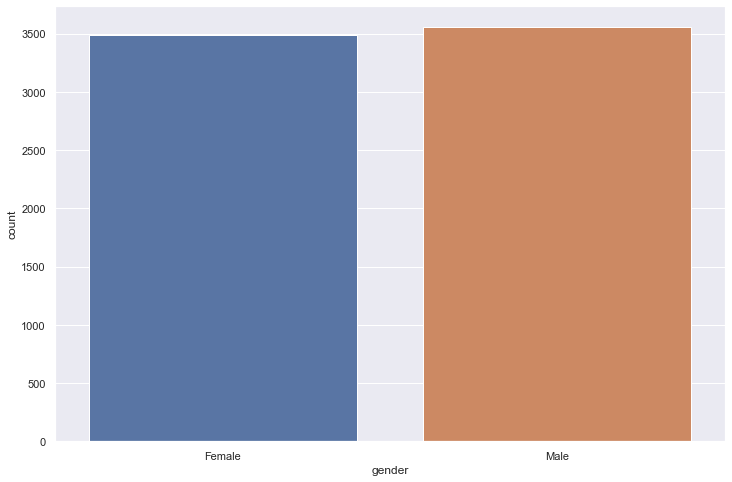

In [37]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('gender',data=df1_new)
# The count of Male and Female looks almost the same

<AxesSubplot:xlabel='gender', ylabel='MonthlyCharges'>

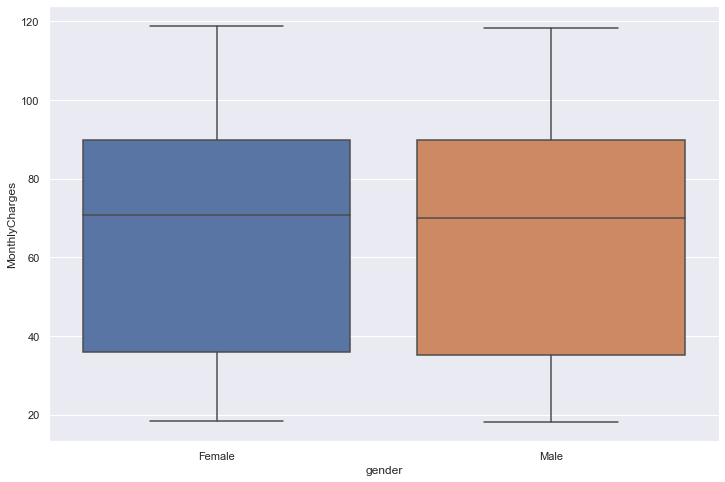

In [38]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='gender',y='MonthlyCharges',data=df1_new)
#Equal contribution from both male and female for monthly charges

<AxesSubplot:xlabel='gender', ylabel='TotalCharges'>

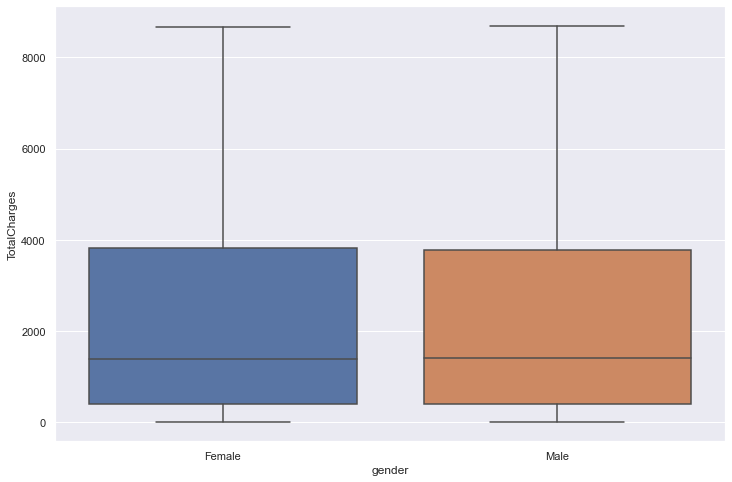

In [39]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='gender',y='TotalCharges',data=df1_new)
#Equal contribution from both male and female for Total charges

In [40]:
df1_new.groupby(['gender'])['TotalCharges'].mean()
# Viewing the same in numbers

gender
Female    2283.190985
Male      2283.407861
Name: TotalCharges, dtype: float64

In [41]:
df1_new.groupby(['gender'])['MonthlyCharges'].mean()
# Viewing the same in numbers

gender
Female    65.204243
Male      64.327482
Name: MonthlyCharges, dtype: float64

In [42]:
df1_new.groupby(['gender','Churn'])['TotalCharges'].mean()
# Vieweing  total charges according to gender that churns or not

gender  Churn
Female  No       2594.054422
        Yes      1440.979499
Male    No       2517.742402
        Yes      1623.491559
Name: TotalCharges, dtype: float64

In [43]:
df1_new.groupby(['gender','Churn'])['MonthlyCharges'].mean()
# Vieweing Monthly charges according to gender that churns or not

gender  Churn
Female  No       61.664908
        Yes      74.812087
Male    No       60.876914
        Yes      74.066989
Name: MonthlyCharges, dtype: float64

In [44]:
df1_new.groupby(['Churn'])['MonthlyCharges'].mean()
#Viewing Monthly charges that churns or not, Those who have more of average monthly charges tend to churn out
#EG: If a gym has an option of paying 3000/month as fees if you pay monthly and 20000/year fees if you pay for whole year
#then those who pay monthly fees will tend to have more monthly charges along with other expenditure, whereas if someone
#pays for the whole year, they tend to have very less monthly charges as they make 1 time payment which also saves them
#16000 per year when compared to monthly payees

Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

In [45]:
df1_new.groupby(['Churn'])['TotalCharges'].mean()
# Vieweing Total charges that churns or not, those who have very less total charges churn out and vice versa

Churn
No     2555.344141
Yes    1531.796094
Name: TotalCharges, dtype: float64

<AxesSubplot:xlabel='gender', ylabel='count'>

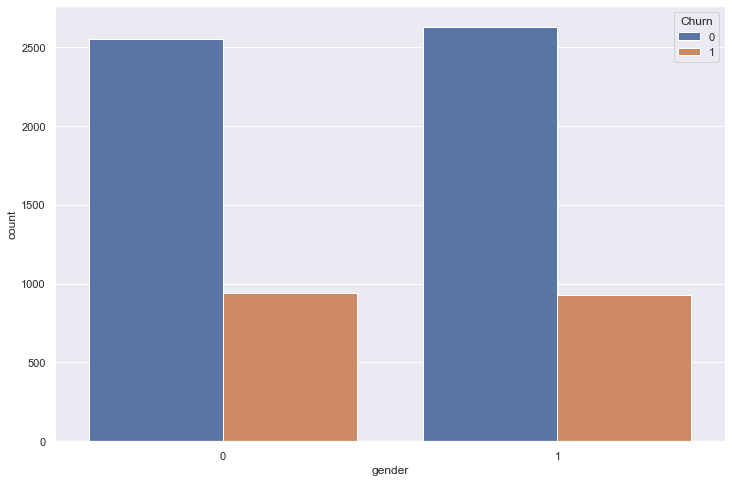

In [46]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('gender',data=new_data_df, hue='Churn')
# Checking Churns counts for both male and female, looks almost same 

# Checking SeniorCitizen

In [47]:
df1_new.groupby(['SeniorCitizen'])['TotalCharges'].mean()
#Checking the average total charges of Senior citizens, if you are a Senior citizen, you tend to have more total charges

SeniorCitizen
0    2181.089550
1    2810.465193
Name: TotalCharges, dtype: float64

In [48]:
df1_new.groupby(['SeniorCitizen'])['MonthlyCharges'].mean()
#Checking the average Monthly charges of Senior citizens,if you are a Senior citizen, you tend to have more Monthly charges as well

SeniorCitizen
0    61.847441
1    79.820359
Name: MonthlyCharges, dtype: float64

In [49]:
df1_new.groupby(['SeniorCitizen','Churn'])['TotalCharges'].mean()
#Checking the average of total charges for senior citizens that churn|those who have less average total charges tend to churn more

SeniorCitizen  Churn
0              No       2416.298799
               Yes      1421.767229
1              No       3494.213363
               Yes      1853.792332
Name: TotalCharges, dtype: float64

In [50]:
df1_new.groupby(['SeniorCitizen','Churn'])['MonthlyCharges'].mean()
#Checking the average of Monthly charges for senior citizens that churn|those who have more avg monthly charges tend to churn

SeniorCitizen  Churn
0              No       58.618123
               Yes      72.298098
1              No       79.182057
               Yes      80.713445
Name: MonthlyCharges, dtype: float64

<AxesSubplot:xlabel='SeniorCitizen', ylabel='TotalCharges'>

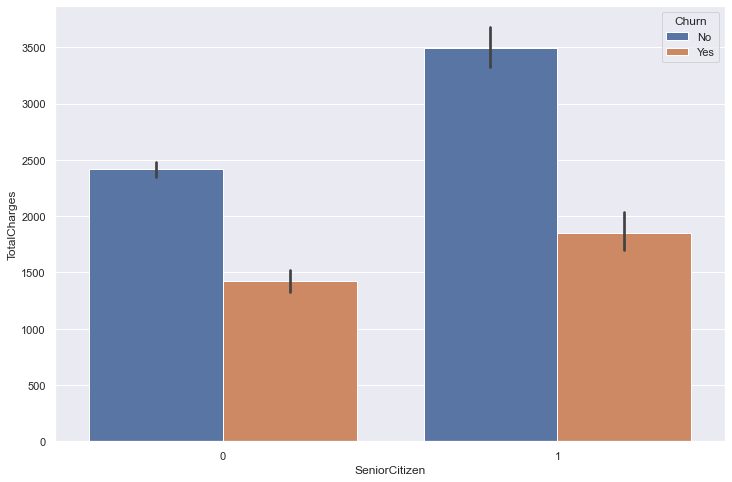

In [51]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.barplot('SeniorCitizen','TotalCharges',data=df1_new,hue='Churn')
# The above explanation, Can be seen in plot for total charges

<AxesSubplot:xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

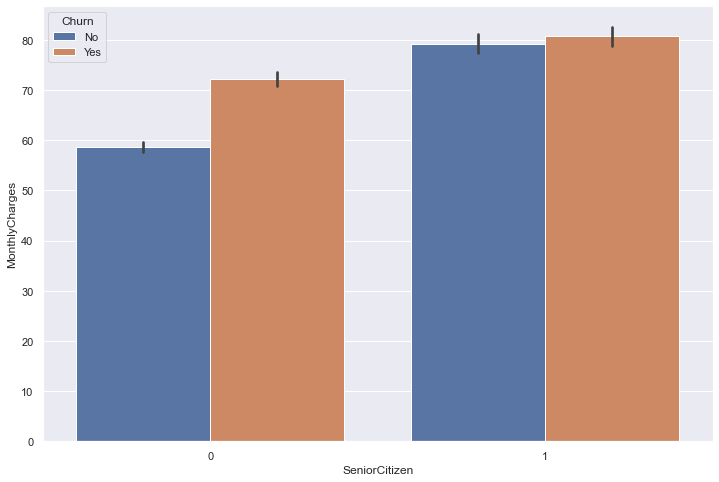

In [52]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.barplot('SeniorCitizen','MonthlyCharges',data=df1_new,hue='Churn')
# The above explanation, Can be seen in plot for monthly charges

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

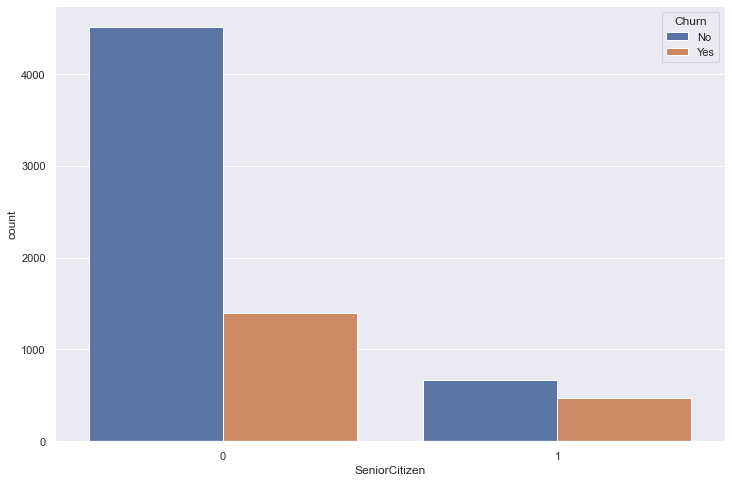

In [53]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('SeniorCitizen',data=df1_new,hue='Churn')
#number of senior citizen that churn and do not,what we see here is that the no of senior citizens is less
# and If you are not a senior citizen the chances of you not churning is more than being a senior citizen

# Checking Partner

In [54]:
df1_new.groupby(['Partner','Churn'])['TotalCharges'].mean()
#Those who have no partners tend to have less charges, those who have partners tend to have more charges which is obvious
#In general those who tend to have more avg total charges do not churn whereas those who have less avg total charges tend to churn

Partner  Churn
No       No       1828.985096
         Yes      1088.980292
Yes      No       3205.707471
         Yes      2326.084529
Name: TotalCharges, dtype: float64

In [55]:
df1_new.groupby(['Partner','Churn'])['MonthlyCharges'].mean()
#The same comparison with average monthly charges

Partner  Churn
No       No       57.271856
         Yes      71.450958
Yes      No       64.831742
         Yes      79.805232
Name: MonthlyCharges, dtype: float64

<AxesSubplot:xlabel='Partner', ylabel='TotalCharges'>

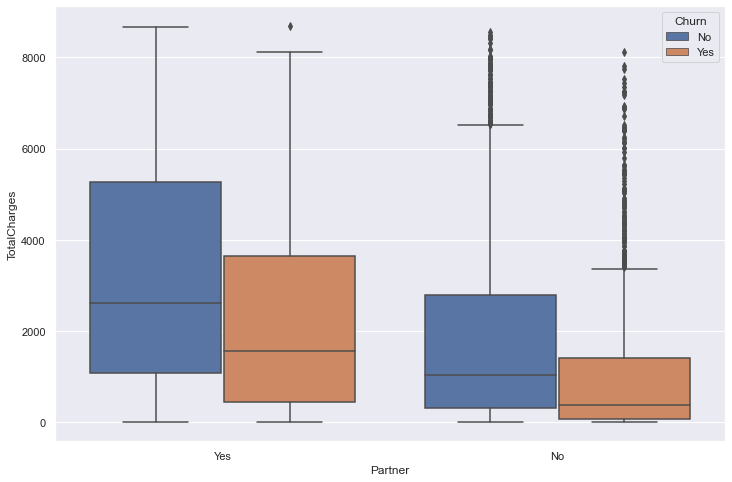

In [56]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot('Partner','TotalCharges',data=df1_new,hue='Churn')
#The above content is show in plots

<AxesSubplot:xlabel='Partner', ylabel='MonthlyCharges'>

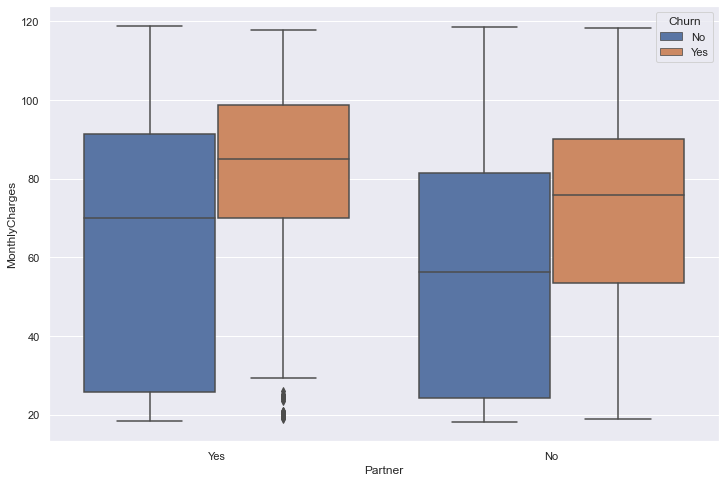

In [57]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot('Partner','MonthlyCharges',data=df1_new,hue='Churn')
#The above content is show in plots, its evident that those who have higher monthly charges tend to churn 


<AxesSubplot:xlabel='Partner', ylabel='count'>

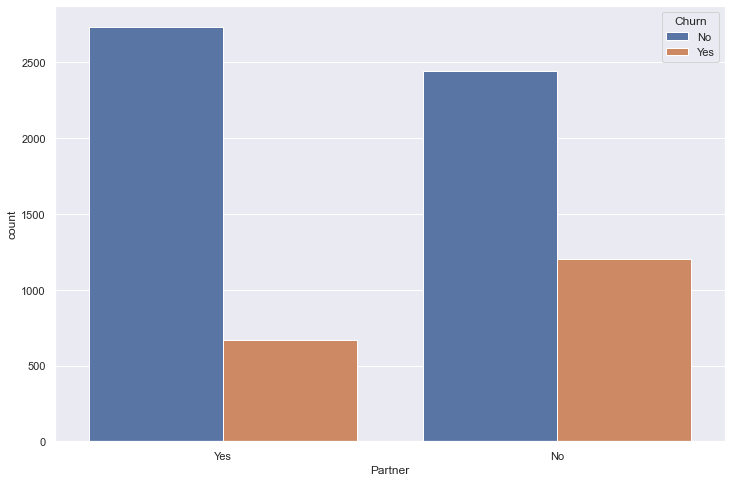

In [58]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('Partner',data=df1_new,hue='Churn')
#The number of churning is more if there is no partner but comaritively less if there is partner, its obvious if you
#have a partner you tend to have another person who might want to have internet 

# Dependents

In [59]:
new_data_df.groupby(['Dependents'])['Churn'].sum()
#If you do not have dependents ,more chances of churning but if you have dependents there is very less chances of churning

Dependents
0    1543.0
1     326.0
Name: Churn, dtype: float64

In [60]:
df1_new.groupby(['Dependents','Churn'])['MonthlyCharges'].mean()
#In comparison with Average  monthly charges

Dependents  Churn
No          No       63.465590
            Yes      74.774141
Yes         No       57.083744
            Yes      72.866104
Name: MonthlyCharges, dtype: float64

In [61]:
df1_new.groupby(['Dependents','Churn'])['TotalCharges'].mean()
#In comparison with Average Total charges

Dependents  Churn
No          No       2516.262478
            Yes      1465.871646
Yes         No       2630.068810
            Yes      1843.825000
Name: TotalCharges, dtype: float64

<AxesSubplot:xlabel='Dependents', ylabel='TotalCharges'>

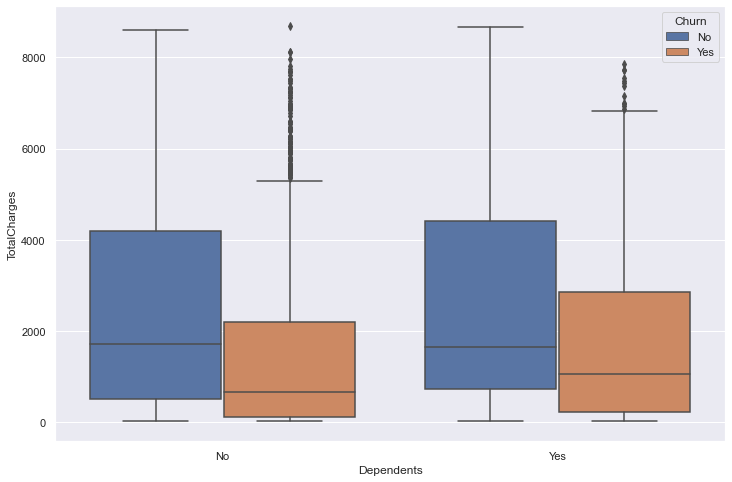

In [62]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot('Dependents','TotalCharges',data=df1_new,hue='Churn')

<AxesSubplot:xlabel='Dependents', ylabel='count'>

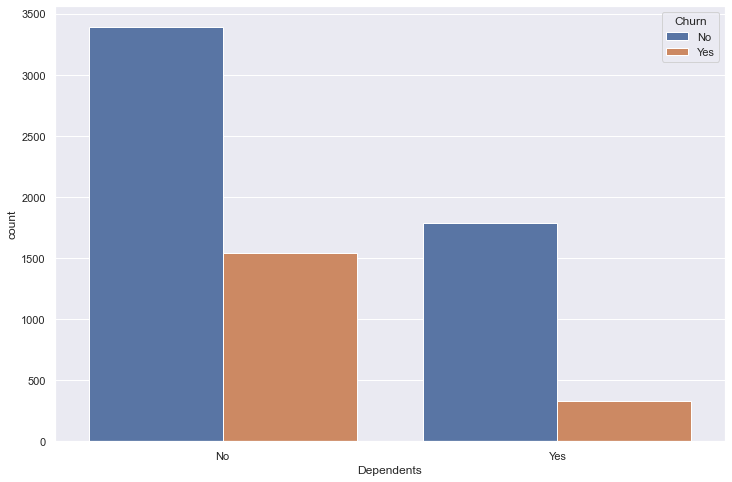

In [63]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('Dependents',data=df1_new,hue='Churn')
#This plot explains things more clearly, in dependents category there are very less churns but in non dependents category
# there are more churns

# tenure

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

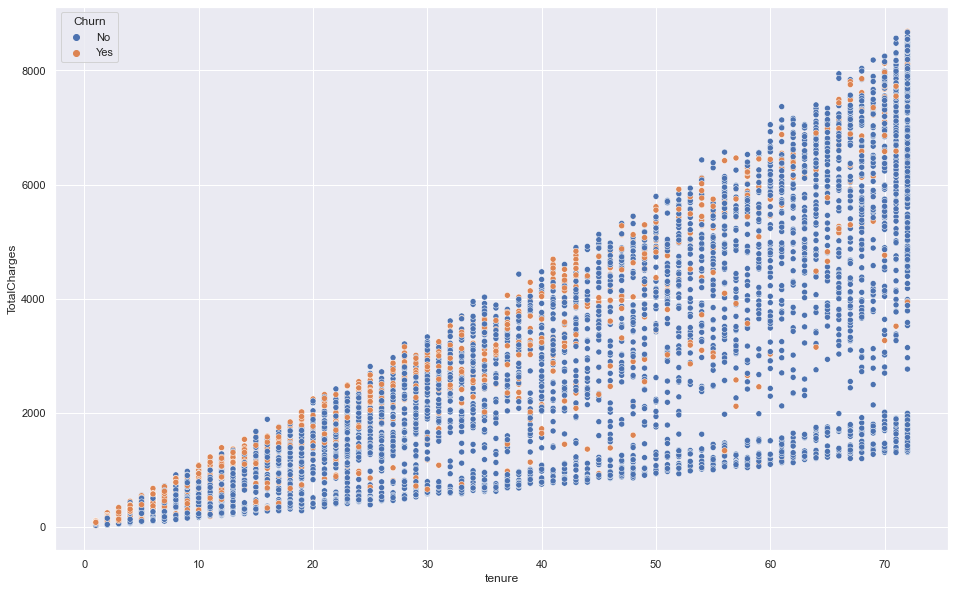

In [64]:
sns.set(color_codes=True)
plt.figure(figsize=(16,10))
sns.scatterplot('tenure','TotalCharges',data=df1_new,hue='Churn')
#when the tenurity increases, the amount of churn decreases - less tenurity contributes to churning

<AxesSubplot:xlabel='tenure', ylabel='MonthlyCharges'>

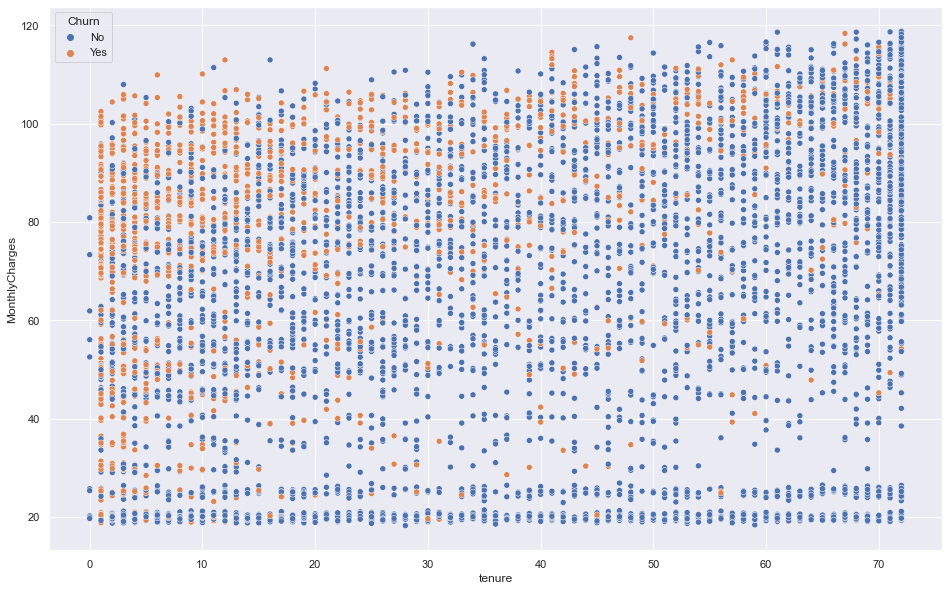

In [65]:
sns.set(color_codes=True)
plt.figure(figsize=(16,10))
sns.scatterplot('tenure','MonthlyCharges',data=df1_new,hue='Churn')
#Even when compared with monthly charges, when the tenurity increases we see very less churning even though more monthly 
#charges usually make for churning

<AxesSubplot:xlabel='SeniorCitizen', ylabel='tenure'>

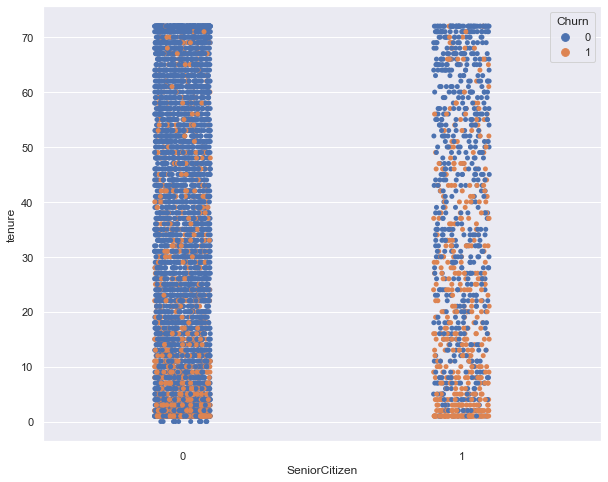

In [66]:
sns.set(color_codes=True)
plt.figure(figsize=(10,8))
sns.stripplot(x ='SeniorCitizen', y ='tenure', data = new_data_df, hue ='Churn') 
#If you are not a senior citizen, which means a youngster might require more internet while working whereas if you are
# a senior citizen who has mostly retired might not require internet much, we see more churns in senior citizens with less
#tenure than with more tenure which means the older people who run business might be using internet for a long time.

# PhoneService

In [67]:
df1_new.groupby(['PhoneService','Churn'])['TotalCharges'].mean()

PhoneService  Churn
No            No       1771.549020
              Yes       687.087941
Yes           No       2641.253342
              Yes      1616.316627
Name: TotalCharges, dtype: float64

<AxesSubplot:xlabel='PhoneService', ylabel='TotalCharges'>

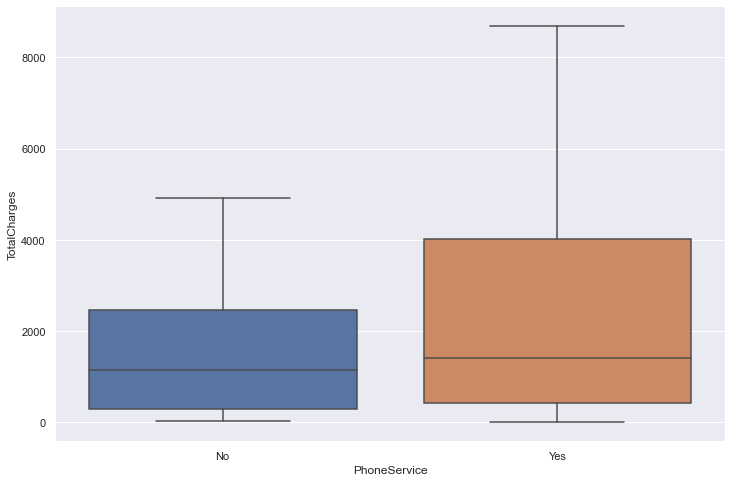

In [68]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='PhoneService',y='TotalCharges',data=df1_new)
#Phone service takes more of total charges

<AxesSubplot:xlabel='PhoneService', ylabel='MonthlyCharges'>

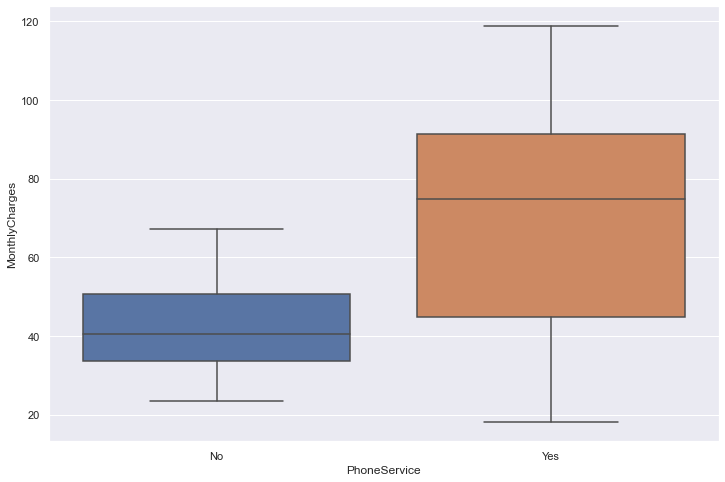

In [69]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='PhoneService',y='MonthlyCharges',data=df1_new)
#Phone service takes more of monhtly charges as well 

<AxesSubplot:xlabel='PhoneService', ylabel='MonthlyCharges'>

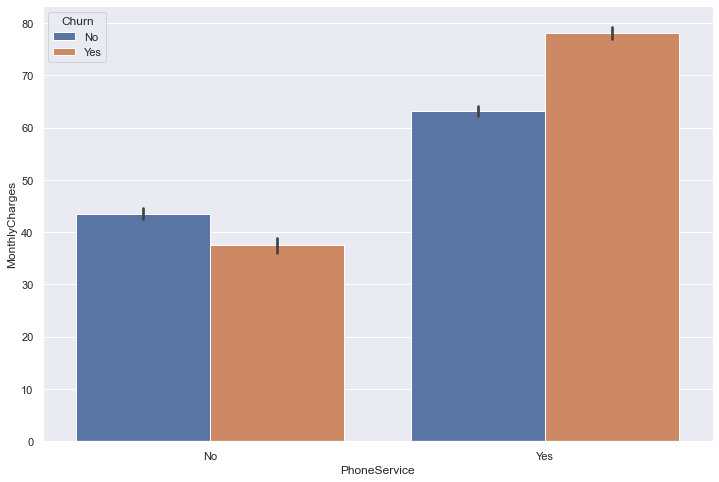

In [70]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.barplot(x='PhoneService',y='MonthlyCharges',data=df1_new,hue='Churn')
#Those who have phone service with more monthly charge , they churn out a lot

<AxesSubplot:xlabel='PhoneService', ylabel='TotalCharges'>

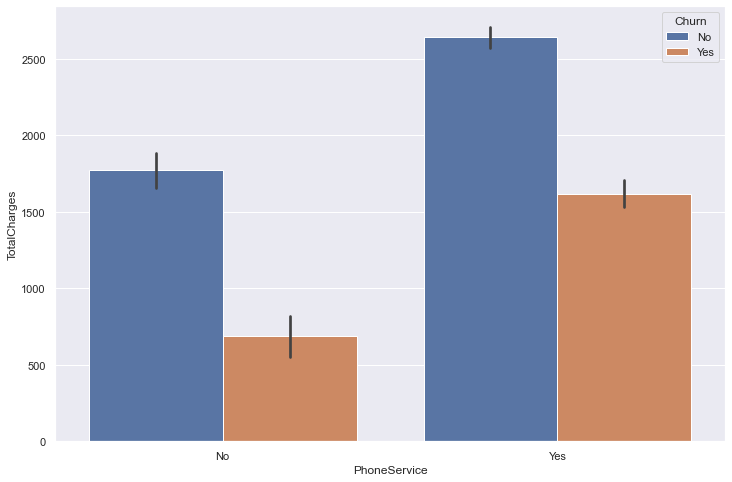

In [71]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.barplot(x='PhoneService',y='TotalCharges',data=df1_new,hue='Churn')
#Those who have phone service with more Total charge , they churn out a lot less compared to monthly charges

# MultipleLines

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

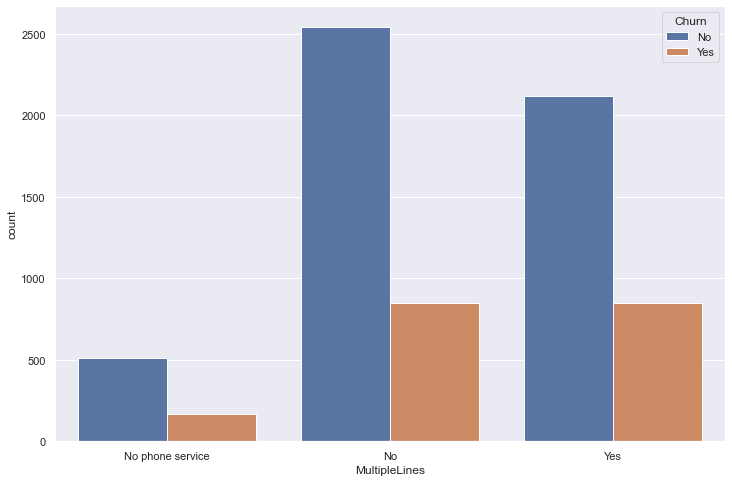

In [72]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('MultipleLines',data=df1_new,hue='Churn')
# The chances of not churning is more on no multiple lines than on multiple lines

<AxesSubplot:xlabel='MultipleLines', ylabel='MonthlyCharges'>

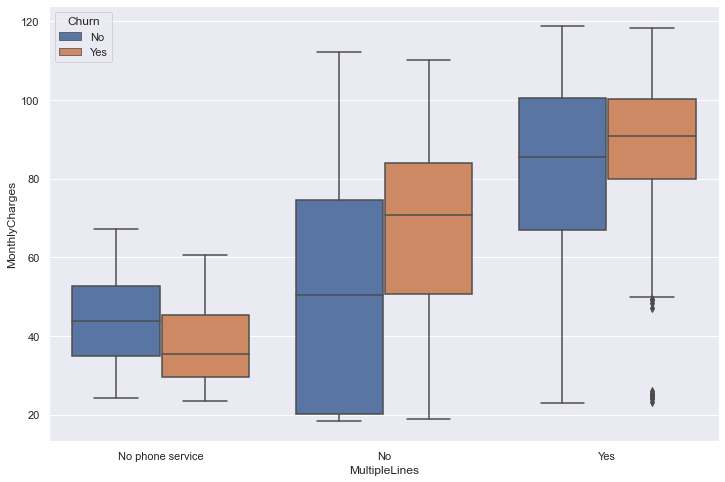

In [73]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='MultipleLines',y='MonthlyCharges',data=df1_new,hue='Churn')

<AxesSubplot:xlabel='MultipleLines', ylabel='TotalCharges'>

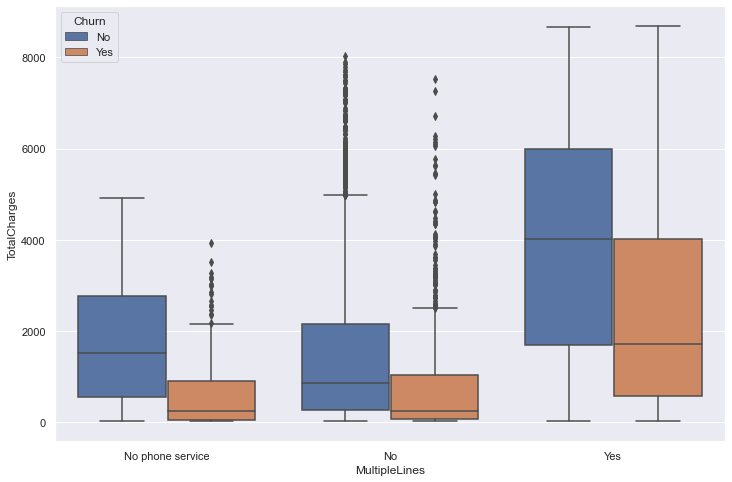

In [74]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='MultipleLines',y='TotalCharges',data=df1_new,hue='Churn')

# InternetService     

In [75]:
df1_new.groupby(['InternetService'])['TotalCharges'].mean()
#The average total charges of fiber optic is high as we know it is the fastest than DSL that is comparitively slow

InternetService
DSL            2119.789259
Fiber optic    3205.304570
No              665.220329
Name: TotalCharges, dtype: float64

In [76]:
new_data_df.groupby(['InternetService'])['Churn'].sum()


InternetService
0     113.0
1     459.0
2    1297.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='InternetService', ylabel='TotalCharges'>

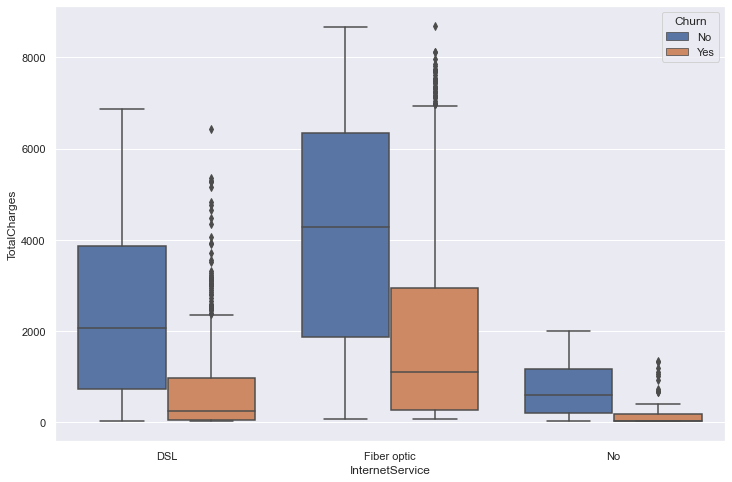

In [77]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='InternetService',y='TotalCharges',data=df1_new,hue='Churn')
#The average total charges of fiber optic that churns high

<AxesSubplot:xlabel='InternetService', ylabel='count'>

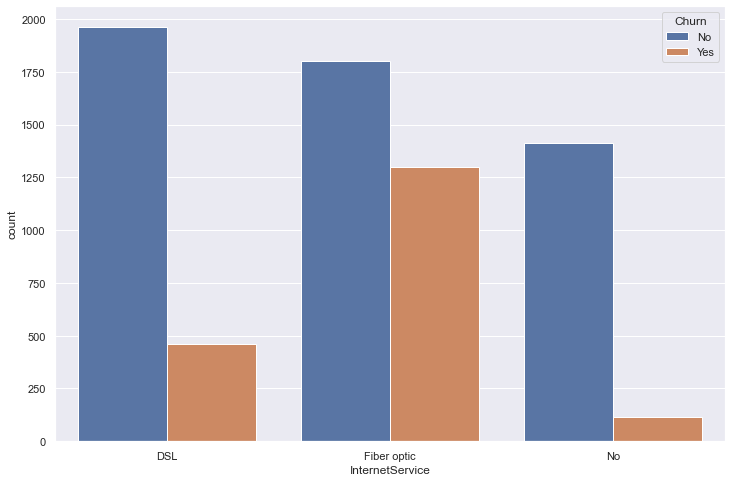

In [78]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('InternetService',data=df1_new,hue='Churn')     
#More churns on fiberoptic and less churns on DSL which is strange

# OnlineSecurity      

In [79]:
df1_new.groupby(['OnlineSecurity'])['Churn'].count()
# Yes- those who have internet and also online security, No- Those who have internet but not online security, 
#no internet service- those who do not have internet and they don need online security

OnlineSecurity
No                     3498
No internet service    1526
Yes                    2019
Name: Churn, dtype: int64

<AxesSubplot:xlabel='OnlineSecurity', ylabel='count'>

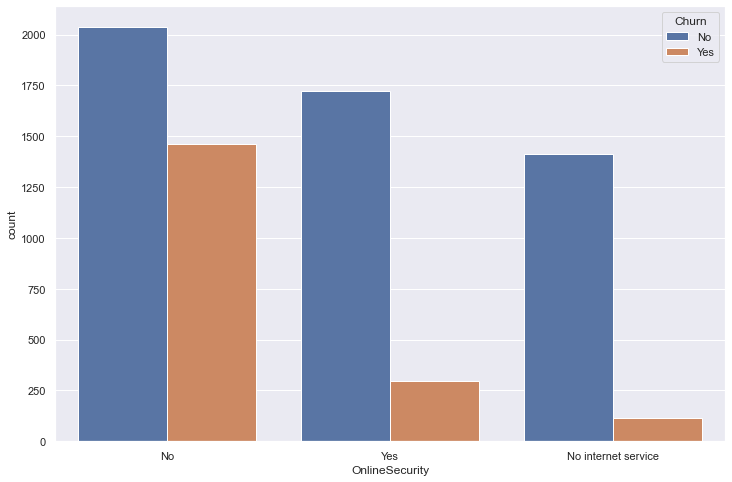

In [80]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('OnlineSecurity',data=df1_new,hue='Churn')     
#It is clear that one who have internet but not online security tend to churn a lot as they will be attacked more often
#by hackers and cyber theives 

<AxesSubplot:xlabel='OnlineSecurity', ylabel='TotalCharges'>

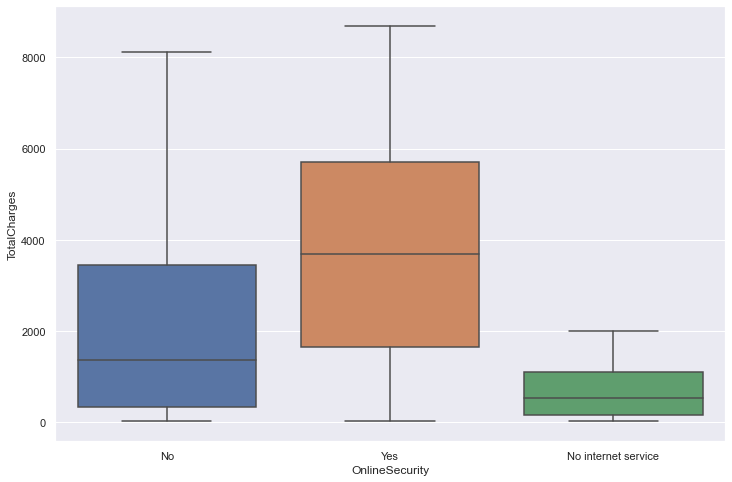

In [81]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='OnlineSecurity',y='TotalCharges',data=df1_new)
#Those who have online security have more total charges which is known

# OnlineBackup

In [43]:
new_data_df.groupby(['OnlineBackup'])['Churn'].sum()
#thosr who have internet but no online backup tend to churn more than those who do

OnlineBackup
0     113.0
1    1233.0
2     523.0
Name: Churn, dtype: float64

In [83]:
new_data_df.groupby(['OnlineBackup'])['Churn'].sum()
#Those who have online backup (label encoded to 2) churn less as they will be frequent internet users

OnlineBackup
0     113.0
1    1233.0
2     523.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='OnlineBackup', ylabel='count'>

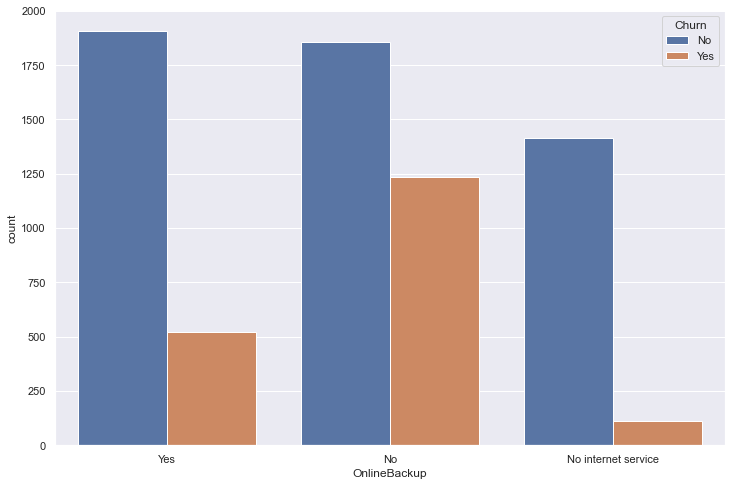

In [84]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('OnlineBackup',data=df1_new,hue='Churn')     
#Those who have online backup churn comparitively lesser compared to the ones with no online backup

<AxesSubplot:xlabel='OnlineBackup', ylabel='TotalCharges'>

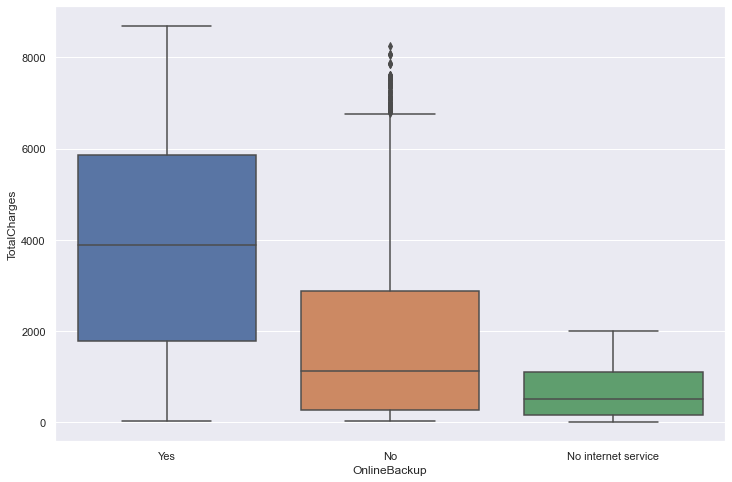

In [85]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='OnlineBackup',y='TotalCharges',data=df1_new)
#The average total charges for those who have online backup is more

# DeviceProtection

In [39]:
new_data_df.groupby(['DeviceProtection'])['Churn'].sum()

DeviceProtection
0     113.0
1    1211.0
2     545.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='DeviceProtection', ylabel='count'>

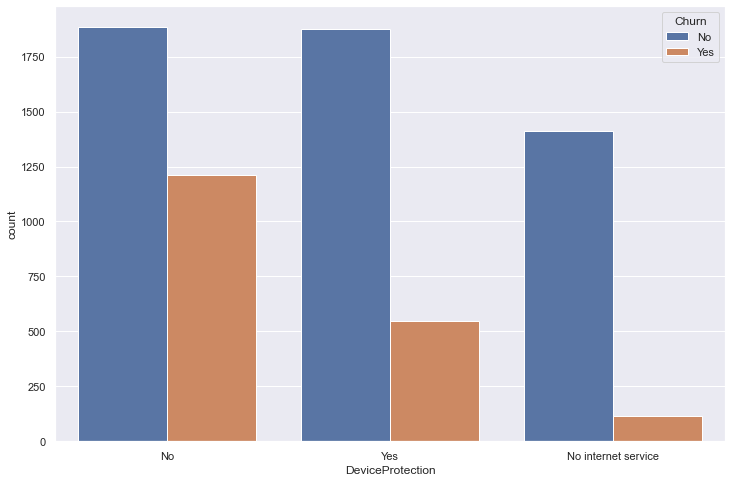

In [87]:
plt.figure(figsize=(12,8))
sns.countplot('DeviceProtection',data=df1_new,hue='Churn')     
#Same as above those who have device protection churn a lot lesser than those who have internet but no device protection

<AxesSubplot:xlabel='DeviceProtection', ylabel='TotalCharges'>

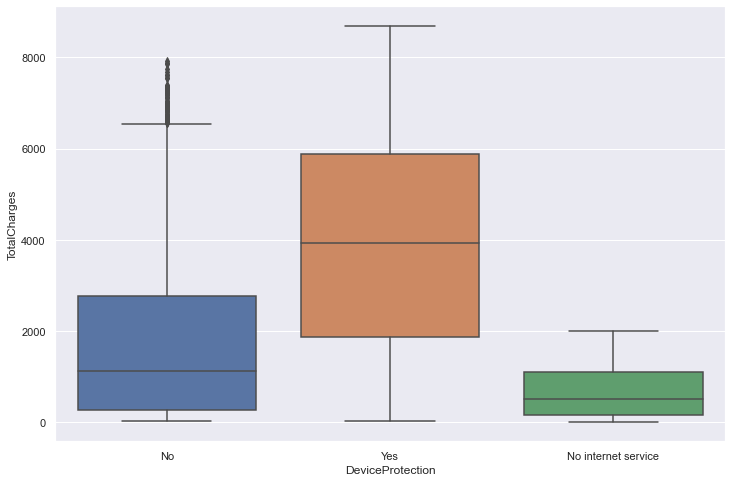

In [88]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='DeviceProtection',y='TotalCharges',data=df1_new)
#Those who have device protection has more total charges

# TechSupport

In [89]:
new_data_df.groupby(['TechSupport'])['Churn'].sum()
#Those who have tech support churn less - label encoded to 2

TechSupport
0     113.0
1    1446.0
2     310.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='TechSupport', ylabel='count'>

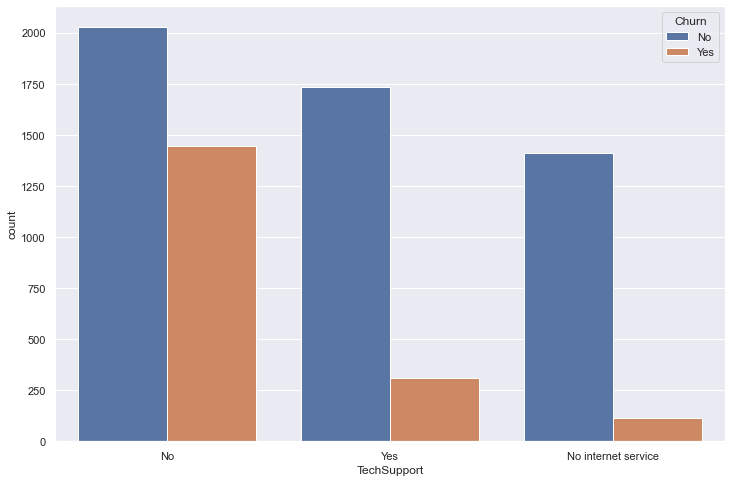

In [90]:
plt.figure(figsize=(12,8))
sns.countplot('TechSupport',data=df1_new,hue='Churn')     

<AxesSubplot:xlabel='TechSupport', ylabel='TotalCharges'>

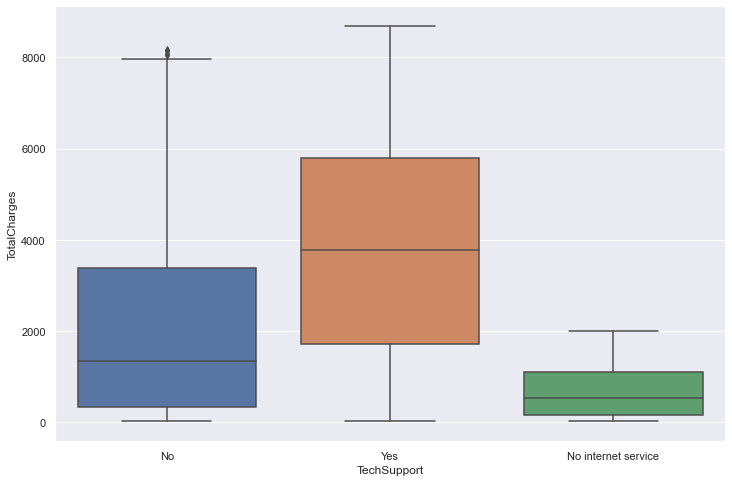

In [91]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='TechSupport',y='TotalCharges',data=df1_new)
#Those who have Tech support has more total charges


# StreamingTV

In [92]:
new_data_df.groupby(['StreamingTV'])['Churn'].sum()

StreamingTV
0    113.0
1    942.0
2    814.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='StreamingTV', ylabel='count'>

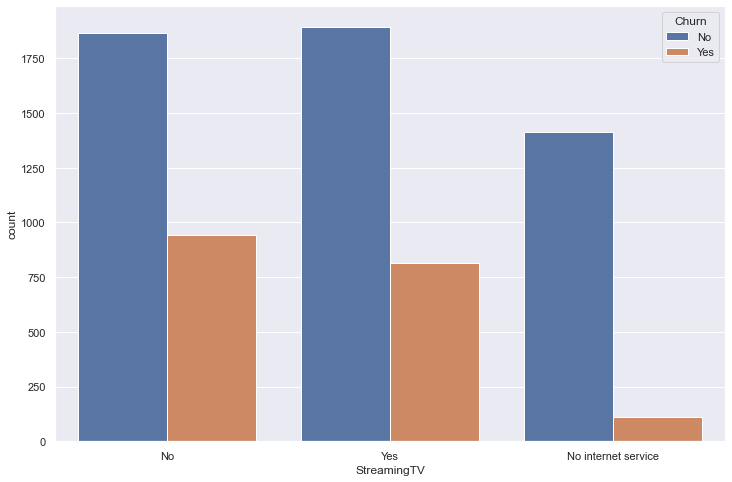

In [93]:
plt.figure(figsize=(12,8))
sns.countplot('StreamingTV',data=df1_new,hue='Churn')    
#Those who have streaming tv tend to churn less as they will be used to watching a lot of online series and they want
# to continue using it

<AxesSubplot:xlabel='StreamingTV', ylabel='TotalCharges'>

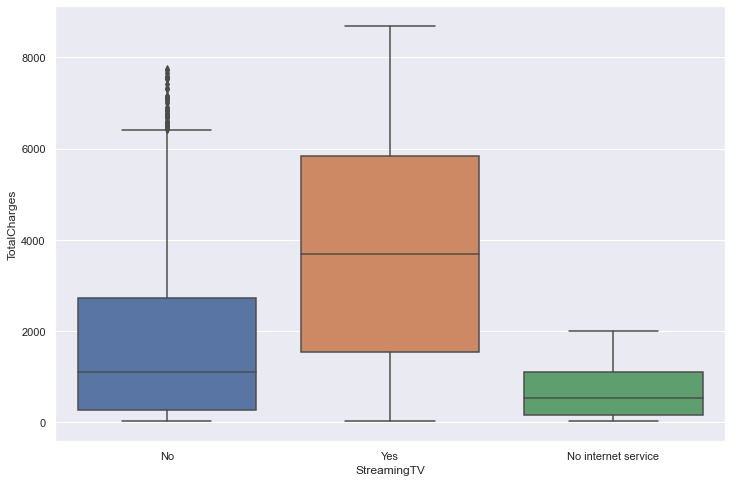

In [94]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='StreamingTV',y='TotalCharges',data=df1_new)
#Total charges on streaming tv is more

# StreamingMovies

In [95]:
new_data_df.groupby(['StreamingMovies'])['Churn'].sum()
# Those who have internet but do not use streaming movies feature tend to churn little extra and those who use the streaming movies
# who tend to churn a little less

StreamingMovies
0    113.0
1    938.0
2    818.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

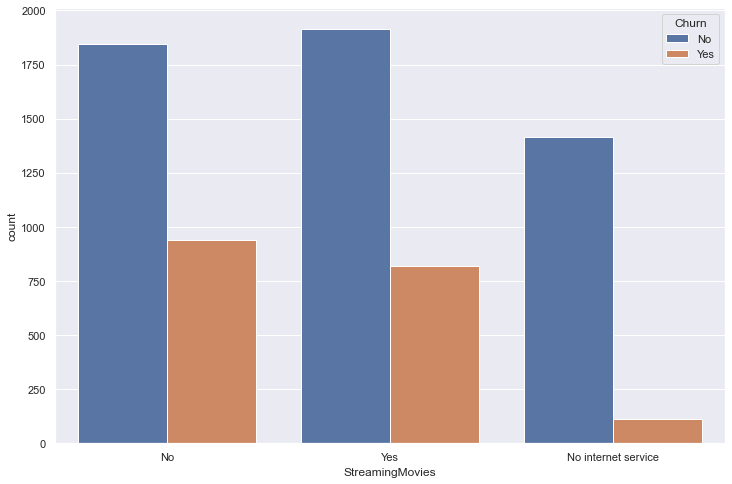

In [96]:
plt.figure(figsize=(12,8))
sns.countplot('StreamingMovies',data=df1_new,hue='Churn')     
#similar to streaming tv

<AxesSubplot:xlabel='StreamingMovies', ylabel='TotalCharges'>

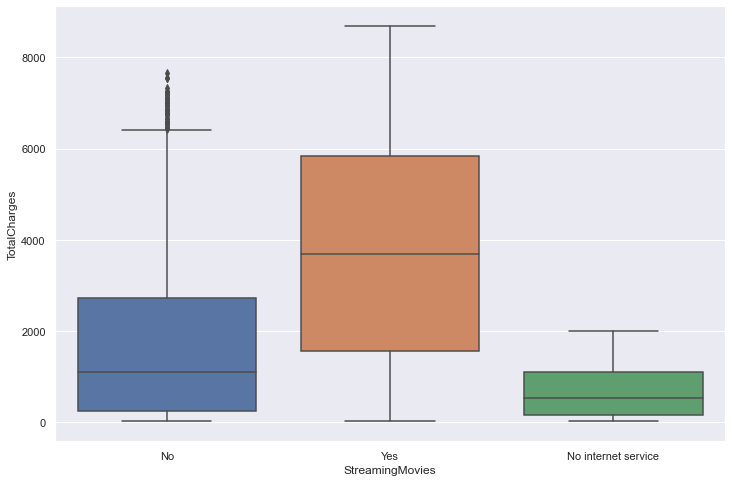

In [97]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='StreamingMovies',y='TotalCharges',data=df1_new)

# Contract

In [98]:
new_data_df.groupby(['Contract'])['Churn'].sum()

Contract
0    1655.0
1     166.0
2      48.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='Contract', ylabel='count'>

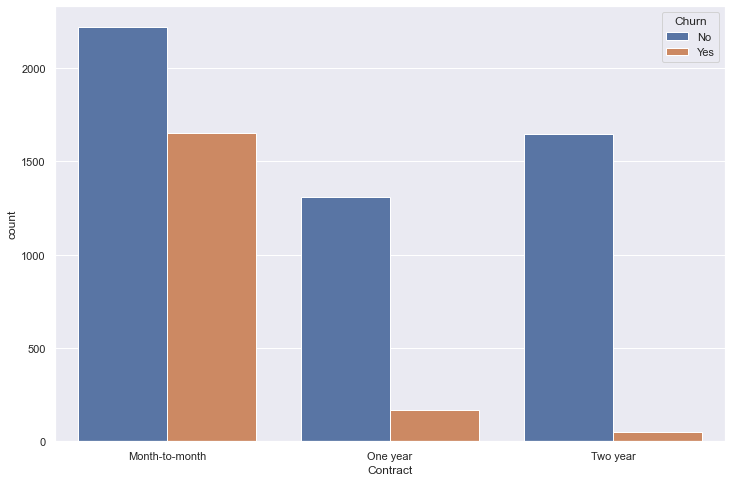

In [99]:
plt.figure(figsize=(12,8))
sns.countplot('Contract',data=df1_new,hue='Churn')     
# Those who take month to month contract end up churning more as a 1 year contract for example might get more benifits with higher
# internet speed, discount price, more months free and for 2 years contract it can be a lot higher


<AxesSubplot:xlabel='Contract', ylabel='MonthlyCharges'>

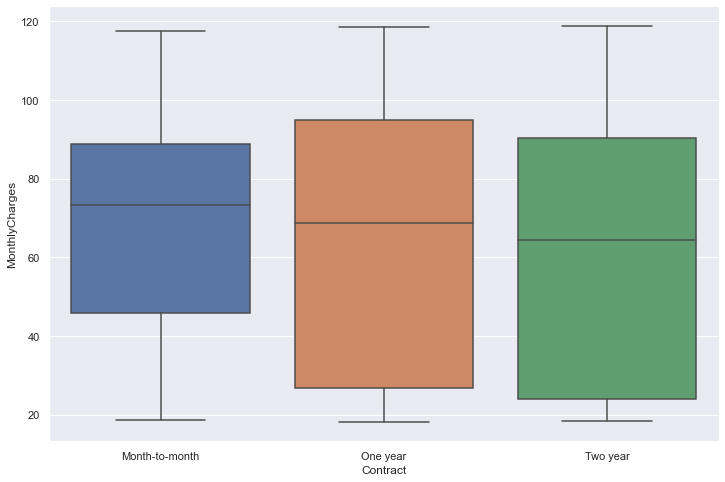

In [100]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='Contract',y='MonthlyCharges',data=df1_new)
#Average of monthly charges for month to month contract is more

# PaperlessBilling

In [101]:
new_data_df.groupby(['PaperlessBilling'])['Churn'].sum()
#Those who are not doing paperless billing are either mostly ones who do not have internet or those who have internet 
#but still choose to do paperless billing so, their chances of churning is less
#Those who do paperless billing are mostly the ones who make use of internet

PaperlessBilling
0     469.0
1    1400.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

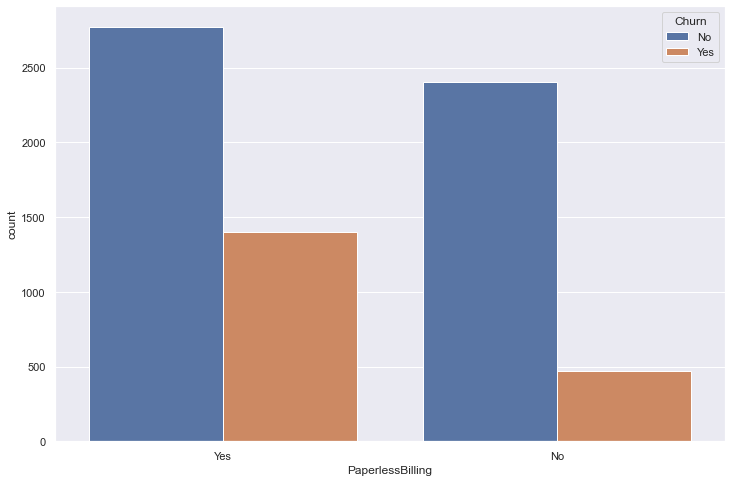

In [102]:
plt.figure(figsize=(12,8))
sns.countplot('PaperlessBilling',data=df1_new,hue='Churn')     

<AxesSubplot:xlabel='PaperlessBilling', ylabel='TotalCharges'>

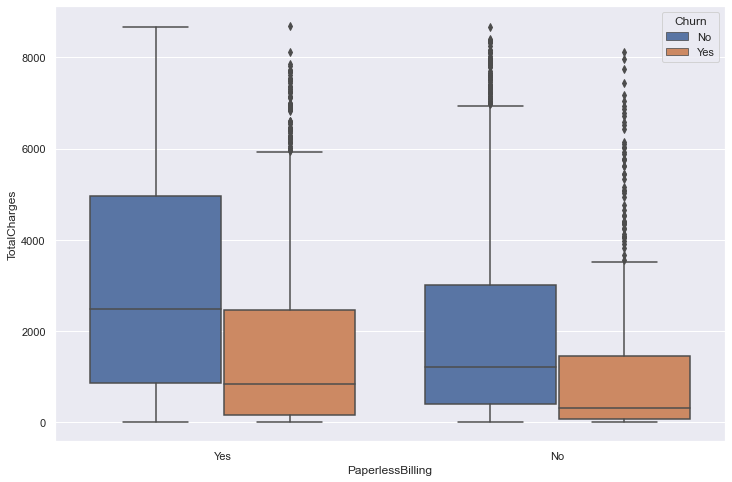

In [103]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='PaperlessBilling',y='TotalCharges',data=df1_new,hue='Churn')

<AxesSubplot:xlabel='PaperlessBilling', ylabel='MonthlyCharges'>

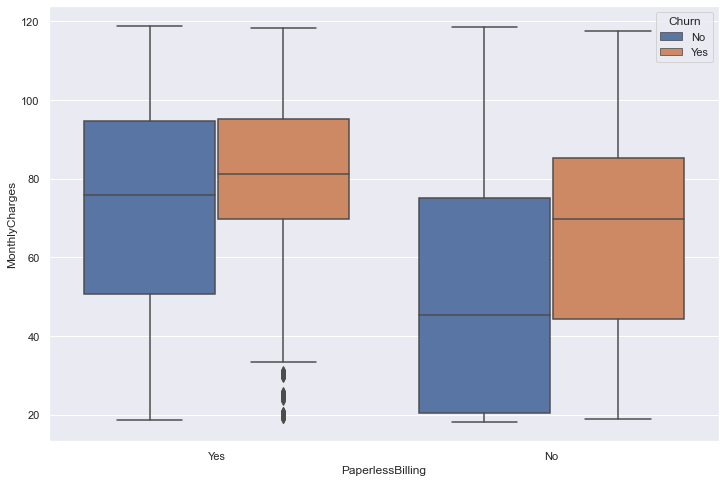

In [104]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='PaperlessBilling',y='MonthlyCharges',data=df1_new,hue='Churn')

# PaymentMethod

In [105]:
new_data_df.groupby(['PaymentMethod'])['Churn'].sum()

PaymentMethod
0     308.0
1     232.0
2    1329.0
Name: Churn, dtype: float64

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

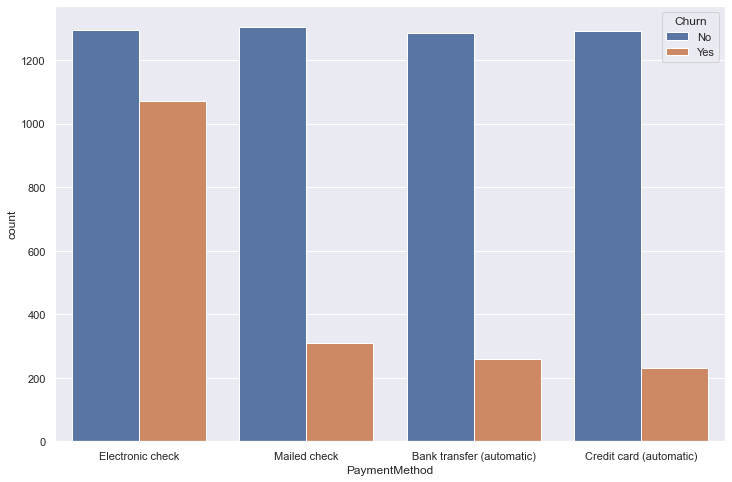

In [106]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.countplot('PaymentMethod',data=df1_new,hue='Churn')
#Those who make electronic check payment end up churning more 

<AxesSubplot:xlabel='PaymentMethod', ylabel='TotalCharges'>

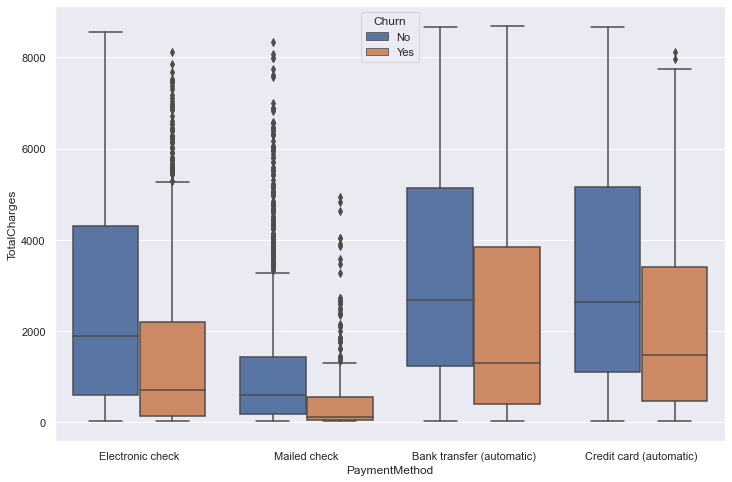

In [107]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x='PaymentMethod',y='TotalCharges',data=df1_new,hue='Churn')

# MonthlyCharges and TotalCharges

In [108]:
new_data_df.groupby(['Churn'])['MonthlyCharges'].mean()
#If your monthly charges is high, you are more likely to churn

Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64

<AxesSubplot:xlabel='Churn', ylabel='MonthlyCharges'>

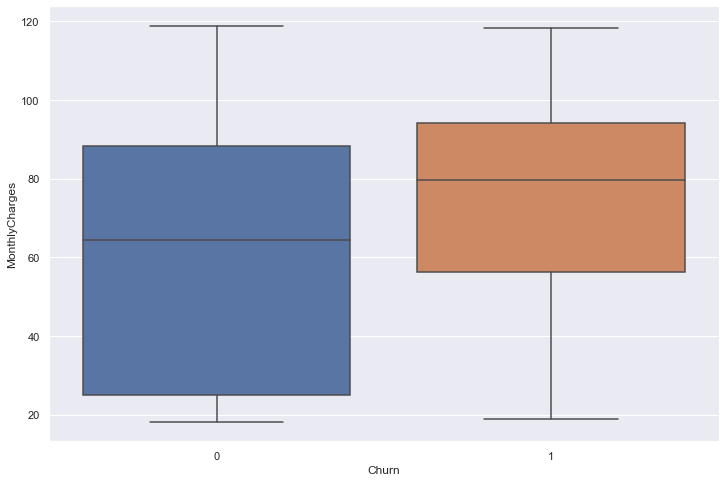

In [109]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x ='Churn', y ='MonthlyCharges', data = new_data_df) 

In [110]:
df1_new.groupby(['Churn'])['TotalCharges'].mean()
#If your monthly charges is high, you are more likely to churn

Churn
No     2555.344141
Yes    1531.796094
Name: TotalCharges, dtype: float64

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

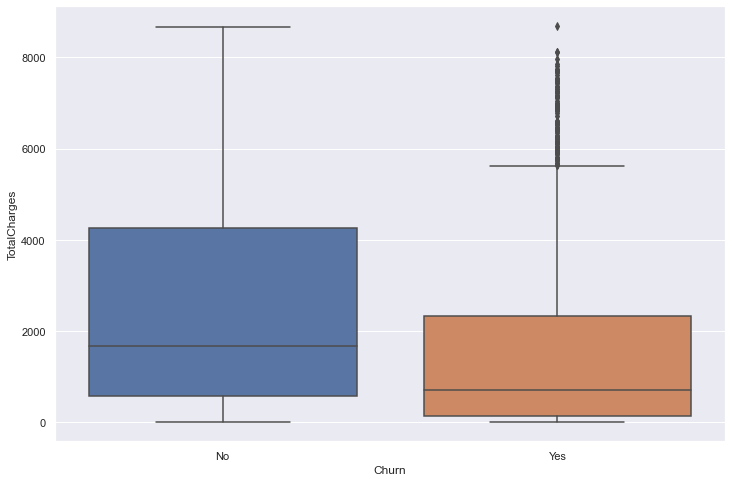

In [111]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(x ='Churn', y ='TotalCharges', data = df1_new) 

<AxesSubplot:xlabel='TotalCharges', ylabel='MonthlyCharges'>

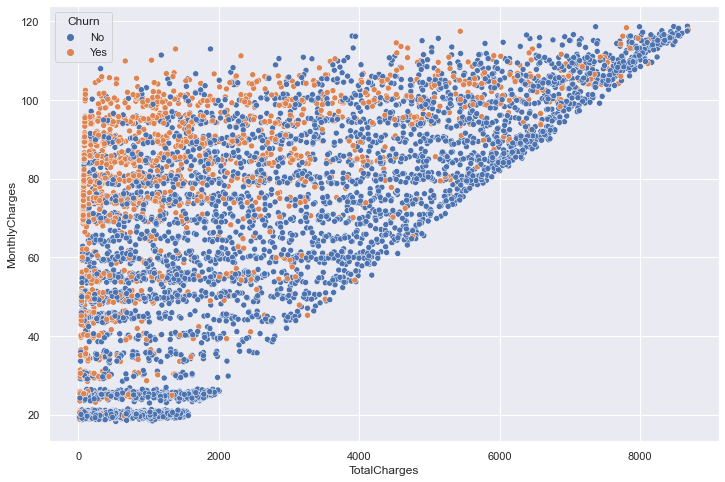

In [112]:
sns.set(color_codes=True)
plt.figure(figsize=(12,8))
sns.scatterplot('TotalCharges','MonthlyCharges',data=df1_new,hue='Churn')
#higher the total charges, lesser the churn - Higher the monthly charges more the churn

# So, now with all multivariate analysis is complete we move on with the data frame "df" which is a complete dataframe without any duplicates

# Data pre-processing:

## Segregate predictors vs target attributes

In [113]:
df = dropnull(df)

In [114]:
df = df.drop('customerID',axis=1)

In [115]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [116]:
categorise(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,1,1,2,2,1,1,1,1,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,2,1,1,1,1,1,1,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,1,2,1,2,2,2,2,1,1,0,84.80,1990.50,0
7039,0,0,1,1,72,1,2,2,1,2,2,1,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,1,2,1,1,1,1,1,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,2,1,1,1,1,1,1,0,1,0,74.40,306.60,1


In [117]:
X = df.drop('Churn',axis=1)
y = df['Churn']

# Check for target balancing and fix it if found imbalanced.

In [118]:
y.value_counts()
#Extremely imbalanced

0    5163
1    1869
Name: Churn, dtype: int64

In [119]:
y.value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

#  To fix imbalancing: Random forest classifier being an ensemble technique is already good at handling data with imbalanced classes

## Found in Url : https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16

# But we will still work on balancing classes and try to get the best score using  balanced classes and using unbalanced classes

## 1. Balancing classes using below 3 methods
### 1.1 Undersampling - us
### 1.2 Oversampling - os
### 1.3 Smote - sm

## 2 . Without balancing and using Ensemble techniques directly

### So, we will have 4 types of metrics to check 1.1,1.2,1.3,2


## 1.1 Undersampling - us

In [120]:
US = NearMiss(0.8)
X_US, y_US= US.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_US.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    2336
1    1869
Name: Churn, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn, dtype: int64 


##  Basically we have done "class1 / 80%" value and have given it to class 0 - Under sampling reduces the higher class a to lower classb/80% times by removing some points

# 1.2 Oversampling - os

In [121]:
OS = RandomOverSampler(0.8)
X_OS, y_OS= OS.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_OS.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    5163
1    4130
Name: Churn, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn, dtype: int64 


# We have increased the class 1 from 1286 to 2908  which is 80% of class0 - Oversampling duplicates same points of  small class

# 1.3 SMOTE - sm

In [231]:
SM = SMOTETomek(0.8)
X_SM, y_SM= SM.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_SM.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    4720
1    3687
Name: Churn_Yes, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn_Yes, dtype: int64 


# Perform train-test split.

In [187]:
#Under sampling
X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X_US, y_US, test_size=0.3,random_state=101)
#OVer sampling
X_train_OS, X_test_OS, y_train_OS, y_test_OS = train_test_split(X_OS, y_OS, test_size=0.3,random_state=101)
#SMOTE
X_train_SM, X_test_SM, y_train_SM, y_test_SM = train_test_split(X_SM, y_SM, test_size=0.3,random_state=101)
#Normal train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

# Check if the train and test data have similar statistical characteristics when compared with original data.

# We use 2 sample t test to check all the train test splits with US,OS,SM and the population that is the actual data


In [70]:
# Ho = Yes,train and test data have similar statistical characteristics when compared with original data
# Ha = Does train and test data have similar statistical characteristics when compared with original data? 

In [87]:
X_data = [X_train,X_test,X_train_US,X_train_OS,X_train_SM,X_test_US,X_test_OS,X_test_SM]

for x_d in X_data:
    t, p = ttest_ind(x_d, X, equal_var=False)
    print(p.mean())
    print(p)

0.7765043518333411
[0.98427925 0.46307864 0.75001279 0.53620837 0.91465283 0.64735511
 0.3987458  0.9693734  0.9693734  0.81217599 0.93023974 0.93471505
 0.93471505 0.69140548 0.93471505 0.7759623  0.93471505 0.73896246
 0.93471505 0.71946717 0.93471505 0.48600062 0.93471505 0.56612905
 0.79512161 0.76981447 0.80052175 0.79815927 0.8464149  0.38867077]
0.6431012835923837
[0.97252994 0.19605036 0.57925541 0.28131669 0.85155328 0.42470141
 0.14699658 0.94642214 0.94642214 0.67868697 0.87844493 0.88597532
 0.88597532 0.491763   0.88597532 0.62065084 0.88597532 0.56251691
 0.88597532 0.53351473 0.88597532 0.22706183 0.88597532 0.31912498
 0.64752058 0.61216151 0.65836982 0.65767928 0.73593908 0.12252885]
0.048883437491908106
[1.33127670e-002 1.32239667e-185 2.07980133e-003 4.88138647e-068
 7.40764343e-001 6.05408399e-024 5.48763737e-011 5.87980178e-003
 5.87980178e-003 1.42397193e-005 3.61902988e-016 1.12592807e-009
 1.12592807e-009 2.75602224e-017 1.12592807e-009 1.30948849e-009
 1.125928

In [88]:
#Since the P value is all greater than alpha, we fail to reject null hypothesis 
# So,Yes train and test data have similar statistical characteristics when compared with original data

# Model training, testing and tuning

# 1 . Decision Tree classifier

### We will take GridCV search

In [125]:
DTC = DecisionTreeClassifier()
SKF = StratifiedKFold(n_splits=10)
gcv = GridSearchCV(estimator = DTC,param_grid = {'max_depth':[5,6,7,8,9,10],'ccp_alpha':[0.0,0.1,0.2]},n_jobs = 5,cv=SKF)

# Normal Train test split - Very bad

In [126]:
gcv.fit(X_train,y_train)
print(f"The best hyper parameter is {gcv.best_params_} and the score is {gcv.best_score_}\n")
pred = gcv.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

The best hyper parameter is {'ccp_alpha': 0.0, 'max_depth': 5} and the score is 0.7842341562360857

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1580
           1       0.57      0.61      0.59       530

    accuracy                           0.79      2110
   macro avg       0.72      0.73      0.72      2110
weighted avg       0.79      0.79      0.79      2110

[[1332  248]
 [ 205  325]]


In [127]:
print(f"The model training data score is{gcv.score(X_train,y_train)}")
print(f"The models test data score {gcv.score(X_test,y_test)}")


The model training data score is0.7945956928078017
The models test data score 0.7853080568720379


# Undersampling train test split - bad

In [128]:
gcv.fit(X_train_US,y_train_US)
print(f"The best hyper parameter is {gcv.best_params_} and the score is {gcv.best_score_}\n")
pred = gcv.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

The best hyper parameter is {'ccp_alpha': 0.0, 'max_depth': 7} and the score is 0.6694015911449325

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       684
           1       0.64      0.58      0.61       578

    accuracy                           0.66      1262
   macro avg       0.66      0.65      0.65      1262
weighted avg       0.66      0.66      0.66      1262

[[495 189]
 [241 337]]


In [129]:
print(f"The model training data score is{gcv.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv.score(X_test_US,y_test_US)}")


The model training data score is0.746517159361196
The models test data score 0.659270998415214


# Over sampling train test split - comparitively better

In [130]:
gcv.fit(X_train_OS,y_train_OS)
print(f"The best hyper parameter is {gcv.best_params_} and the score is {gcv.best_score_}\n")
pred = gcv.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

The best hyper parameter is {'ccp_alpha': 0.0, 'max_depth': 10} and the score is 0.7740212690535271

              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1553
           1       0.74      0.81      0.78      1235

    accuracy                           0.79      2788
   macro avg       0.79      0.79      0.79      2788
weighted avg       0.80      0.79      0.79      2788

[[1203  350]
 [ 231 1004]]


In [131]:
print(f"The model training data score is{gcv.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv.score(X_test_OS,y_test_OS)}")


The model training data score is0.8710222905457341
The models test data score 0.7916068866571019


# SMOTE train test split - best out of above 4

In [132]:
gcv.fit(X_train_SM,y_train_SM)
print(f"The best hyper parameter is {gcv.best_params_} and the score is {gcv.best_score_}\n")
pred = gcv.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

The best hyper parameter is {'ccp_alpha': 0.0, 'max_depth': 8} and the score is 0.8058813920247367

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1382
           1       0.78      0.82      0.80      1127

    accuracy                           0.81      2509
   macro avg       0.81      0.81      0.81      2509
weighted avg       0.81      0.81      0.81      2509

[[1117  265]
 [ 205  922]]


In [133]:
print(f"The model training data score is{gcv.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv.score(X_test_SM,y_test_SM)}")


The model training data score is0.8663704716336296
The models test data score 0.8126743722598645


# Decision Tree classifier model Analysis :

## The request is : "a model that will help to identify the potential customers who have a higher probability to churn"

## Basically they want to know who have higher chances to churn/leave their telecom connection which relates to a model that needs to have very less False Positives. 

## The model that we make should not have False Negative/ Flasely claim they wont churn when in reality they churn. So, we will take Recall as our priority which will help us identify the False Negative's status.

## We can accept to have few False Positives / Falsely claim they will  churn but in reality they wont churn

# In this case the model with Oversampling applied Train test split helps us by giving a good Recall,Precision and F1 Score but still we scope of improvement.

## Model : Decision Tree classifier, Best maxdepth = 6, data = SMOTE applied data


# 2 . Random Forest Classifier 

In [134]:
RFC = RandomForestClassifier()
SKF1 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc = GridSearchCV(estimator = RFC,param_grid =param_grid1,cv=SKF1,n_jobs=5)

# Normal Train test split - Very bad scores

In [135]:
gcv_rfc.fit(X_train,y_train)
print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
pred = gcv_rfc.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

The best hyper parameter is {'n_estimators': 50, 'n_jobs': 5, 'random_state': 9} and the score is 0.792966572667755

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1580
           1       0.63      0.51      0.56       530

    accuracy                           0.80      2110
   macro avg       0.74      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110

[[1419  161]
 [ 260  270]]


In [136]:
print(f"The model training data score is{gcv_rfc.score(X_train,y_train)}")
print(f"The models test data score {gcv_rfc.score(X_test,y_test)}")


The model training data score is0.997765136123527
The models test data score 0.8004739336492891


# Using Under sampling - very bad scores

In [137]:
RFC1 = RandomForestClassifier()
SKF2 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_US = GridSearchCV(estimator = RFC1,param_grid =param_grid1,cv=SKF2,n_jobs=5)


gcv_rfc_US.fit(X_train_US,y_train_US)
print(f"The best hyper parameter is {gcv_rfc_US.best_params_} and the score is {gcv_rfc_US.best_score_}\n")
pred = gcv_rfc_US.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

The best hyper parameter is {'n_estimators': 90, 'n_jobs': 5, 'random_state': 9} and the score is 0.6768707482993197

              precision    recall  f1-score   support

           0       0.67      0.70      0.68       684
           1       0.62      0.60      0.61       578

    accuracy                           0.65      1262
   macro avg       0.65      0.65      0.65      1262
weighted avg       0.65      0.65      0.65      1262

[[477 207]
 [234 344]]


In [138]:
print(f"The model training data score is{gcv_rfc_US.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv_rfc_US.score(X_test_US,y_test_US)}")


The model training data score is0.9972816853550799
The models test data score 0.650554675118859


# SMOTE train test split - Comparitively better scores

In [139]:
RFC2 = RandomForestClassifier()
SKF3 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_SM = GridSearchCV(estimator = RFC2,param_grid =param_grid1,cv=SKF3,n_jobs=5)


gcv_rfc_SM.fit(X_train_SM,y_train_SM)
print(f"The best hyper parameter is {gcv_rfc_SM.best_params_} and the score is {gcv_rfc_SM.best_score_}\n")
pred = gcv_rfc_SM.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

The best hyper parameter is {'n_estimators': 90, 'n_jobs': 5, 'random_state': 9} and the score is 0.8463784603716344

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1382
           1       0.83      0.82      0.82      1127

    accuracy                           0.84      2509
   macro avg       0.84      0.84      0.84      2509
weighted avg       0.84      0.84      0.84      2509

[[1193  189]
 [ 205  922]]


In [140]:
print(f"The model training data score is{gcv_rfc_SM.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv_rfc_SM.score(X_test_SM,y_test_SM)}")


The model training data score is0.9984620642515379
The models test data score 0.8429653248306098


# Over sampling train test split - Best in previous 4 with high recall for class 1, also good precision and F1 score(Overall)

In [141]:
RFC3 = RandomForestClassifier()
SKF4 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_OS = GridSearchCV(estimator = RFC3,param_grid =param_grid1,cv=SKF4,n_jobs=5)

gcv_rfc_OS.fit(X_train_OS,y_train_OS)
print(f"The best hyper parameter is {gcv_rfc_OS.best_params_} and the score is {gcv_rfc_OS.best_score_}\n")
pred = gcv_rfc_OS.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

The best hyper parameter is {'n_estimators': 90, 'n_jobs': 5, 'random_state': 9} and the score is 0.857490488006617

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1553
           1       0.83      0.88      0.85      1235

    accuracy                           0.87      2788
   macro avg       0.86      0.87      0.86      2788
weighted avg       0.87      0.87      0.87      2788

[[1324  229]
 [ 145 1090]]


In [142]:
print(f"The model training data score is{gcv_rfc_OS.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv_rfc_OS.score(X_test_OS,y_test_OS)}")


The model training data score is0.9981552651806302
The models test data score 0.8658536585365854


# Random Forest classifier model Analysis :

## The request is : "a model that will help to identify the potential customers who have a higher probability to churn"

## Basically they want to know who have higher chances to churn/leave their telecom connection which relates to a model that needs to have very less False Positives. 

## The model that we make should not have False Negative / Flasely claim they wont churn when in reality they churn. So, we will take Recall as our priority which will help us identify the False Negative's status.

## We can accept to have few False positive / Falsely claim they will  churn but in reality they wont churn

# In this case the model with Oversampling applied Train test split helped us by giving a good Recall, Precision and F1 Score although its usually SMOTE that gives a good score.

## Model : Random Forest classifier, 'n_estimators': 50, 'n_jobs': 5, 'random_state': 9, data = Over sampling applied data


# 4. AdaBoostClassifier

## With hyperparameter tuning - normal train and test data

In [143]:
ABC = AdaBoostClassifier()
SKF5 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[10,15,17,19,20,25,40,50,70,90],'random_state':[9]}
gcv_abc = GridSearchCV(estimator = ABC,param_grid =param_grid1,cv=SKF5,n_jobs=5)


gcv_abc.fit(X_train,y_train)
print(f"The best hyper parameter is {gcv_abc.best_params_} and the score is {gcv_abc.best_score_}\n")
pred = gcv_abc.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

The best hyper parameter is {'n_estimators': 50, 'random_state': 9} and the score is 0.8017117696531935

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1580
           1       0.64      0.55      0.59       530

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110

[[1419  161]
 [ 240  290]]


In [144]:
print(f"The model training data score is{gcv_abc.score(X_train,y_train)}")
print(f"The models test data score {gcv_abc.score(X_test,y_test)}")


The model training data score is0.8067858594067452
The models test data score 0.8099526066350711


#  With under sampling data

In [145]:
gcv_abc.fit(X_train_US,y_train_US)
print(f"The best hyper parameter is {gcv_abc.best_params_} and the score is {gcv_abc.best_score_}\n")
pred = gcv_abc.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

The best hyper parameter is {'n_estimators': 70, 'random_state': 9} and the score is 0.6979418886198546

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       684
           1       0.66      0.67      0.66       578

    accuracy                           0.69      1262
   macro avg       0.69      0.69      0.69      1262
weighted avg       0.69      0.69      0.69      1262

[[484 200]
 [192 386]]


In [146]:
print(f"The model training data score is{gcv_abc.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv_abc.score(X_test_US,y_test_US)}")


The model training data score is0.7220523275569147
The models test data score 0.6893819334389857


# With oversampling data

In [147]:
gcv_abc.fit(X_train_OS,y_train_OS)
print(f"The best hyper parameter is {gcv_abc.best_params_} and the score is {gcv_abc.best_score_}\n")
pred = gcv_abc.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

The best hyper parameter is {'n_estimators': 70, 'random_state': 9} and the score is 0.7687954626019142

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1553
           1       0.73      0.76      0.75      1235

    accuracy                           0.77      2788
   macro avg       0.77      0.77      0.77      2788
weighted avg       0.77      0.77      0.77      2788

[[1206  347]
 [ 294  941]]


In [148]:
print(f"The model training data score is{gcv_abc.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv_abc.score(X_test_OS,y_test_OS)}")


The model training data score is0.7746348962336664
The models test data score 0.7700860832137734


# With smote data

In [149]:
gcv_abc.fit(X_train_SM,y_train_SM)
print(f"The best hyper parameter is {gcv_abc.best_params_} and the score is {gcv_abc.best_score_}\n")
pred = gcv_abc.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

The best hyper parameter is {'n_estimators': 90, 'random_state': 9} and the score is 0.8236550859076456

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1382
           1       0.80      0.85      0.82      1127

    accuracy                           0.83      2509
   macro avg       0.83      0.84      0.83      2509
weighted avg       0.84      0.83      0.83      2509

[[1137  245]
 [ 171  956]]


In [150]:
print(f"The model training data score is{gcv_abc.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv_abc.score(X_test_SM,y_test_SM)}")


The model training data score is0.8330485304169515
The models test data score 0.8341968911917098


# Ada boost model Analysis :

## The request is : "a model that will help to identify the potential customers who have a higher probability to churn"

## Basically they want to know who have higher chances to churn/leave their telecom connection which relates to a model that needs to have very less False Positives. 

## The model that we make should not have False Negative/ Flasely claim they wont churn when in reality they churn. So, we will take Recall as our priority which will help us identify the False negative's status.

## We can accept to have few False positive / Falsely claim they will  churn but in reality they wont churn

# In this case the model with SMOTE applied Train test split helped us by giving a good Recall,Precision and F1 Score although its usually SMOTE that gives a good score.

## Model : AdaBoostClassifier , 'n_estimators': 90, 'random_state': 9, data = SMOTE applied data


# 5. Gradient Boost classifier

# X_train and test data

In [151]:
GBC = GradientBoostingClassifier()
SKF6 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[10,15,17,19,20,25,40,50,70,90]}
gcv_GBC = GridSearchCV(estimator = ABC,param_grid =param_grid1,cv=SKF6,n_jobs=5)



gcv_GBC.fit(X_train,y_train)
print(f"The best hyper parameter is {gcv_GBC.best_params_} and the score is {gcv_GBC.best_score_}\n")
pred = gcv_GBC.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

The best hyper parameter is {'n_estimators': 50} and the score is 0.8017117696531935

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1580
           1       0.64      0.55      0.59       530

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110

[[1419  161]
 [ 240  290]]


In [152]:
print(f"The model training data score is{gcv_GBC.score(X_train,y_train)}")
print(f"The models test data score {gcv_GBC.score(X_test,y_test)}")


The model training data score is0.8067858594067452
The models test data score 0.8099526066350711


# Undersampling data

In [153]:
gcv_GBC.fit(X_train_US,y_train_US)
print(f"The best hyper parameter is {gcv_GBC.best_params_} and the score is {gcv_GBC.best_score_}\n")
pred = gcv_GBC.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

The best hyper parameter is {'n_estimators': 70} and the score is 0.6979418886198546

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       684
           1       0.66      0.67      0.66       578

    accuracy                           0.69      1262
   macro avg       0.69      0.69      0.69      1262
weighted avg       0.69      0.69      0.69      1262

[[484 200]
 [192 386]]


In [154]:
print(f"The model training data score is{gcv_GBC.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv_GBC.score(X_test_US,y_test_US)}")


The model training data score is0.7220523275569147
The models test data score 0.6893819334389857


# Oversampling

In [155]:
gcv_GBC.fit(X_train_OS,y_train_OS)
print(f"The best hyper parameter is {gcv_GBC.best_params_} and the score is {gcv_GBC.best_score_}\n")
pred = gcv_GBC.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

The best hyper parameter is {'n_estimators': 70} and the score is 0.7687954626019142

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1553
           1       0.73      0.76      0.75      1235

    accuracy                           0.77      2788
   macro avg       0.77      0.77      0.77      2788
weighted avg       0.77      0.77      0.77      2788

[[1206  347]
 [ 294  941]]


In [156]:
print(f"The model training data score is{gcv_GBC.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv_GBC.score(X_test_OS,y_test_OS)}")


The model training data score is0.7746348962336664
The models test data score 0.7700860832137734


# SMOTE data

In [157]:
gcv_GBC.fit(X_train_SM,y_train_SM)
print(f"The best hyper parameter is {gcv_GBC.best_params_} and the score is {gcv_GBC.best_score_}\n")
pred = gcv_GBC.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

The best hyper parameter is {'n_estimators': 90} and the score is 0.8236550859076456

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1382
           1       0.80      0.85      0.82      1127

    accuracy                           0.83      2509
   macro avg       0.83      0.84      0.83      2509
weighted avg       0.84      0.83      0.83      2509

[[1137  245]
 [ 171  956]]


In [158]:
print(f"The model training data score is{gcv_GBC.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv_GBC.score(X_test_SM,y_test_SM)}")


The model training data score is0.8330485304169515
The models test data score 0.8341968911917098


# Gradient boost model Analysis :

## The request is : "a model that will help to identify the potential customers who have a higher probability to churn"

## Basically they want to know who have higher chances to churn/leave their telecom connection which relates to a model that needs to have very less False Positives. 

## The model that we make should not have False negative/ Flasely claim they wont churn when in reality they churn. So, we will take Recall as our priority which will help us identify the False positive's status.

## We can accept to have few False positives / Falsely claim they will  churn but in reality they wont churn

# In this case the model with SMOTE applied Train test split helped us by giving a good Recall, Precision and F1 Score although its usually SMOTE that gives a good score.

## Model : Gradient boost , 'n_estimators': 90, data = SMOTE applied data


# ***Throughout we applied label encoding technique to convert certain columns to a categorical variable, now we will try to apply dummy variable to all columns***

In [45]:
df_df = pd.read_csv('TelcomCustomer-Churn.csv')
df_df.drop('customerID',axis=1,inplace=True)
df_df.dropna(axis=0, inplace=True)

In [46]:
df_df_dummies = pd.get_dummies(df_df,drop_first=True)

In [47]:
df_df_dummies['Churn_Yes'].value_counts()
#Extremely imbalanced

0    5163
1    1869
Name: Churn_Yes, dtype: int64

In [48]:
X = df_df_dummies.drop('Churn_Yes',axis=1)
y = df_df_dummies['Churn_Yes']

In [49]:
#Undersampling
US = NearMiss(0.8)
X_US, y_US= US.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_US.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    2336
1    1869
Name: Churn_Yes, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn_Yes, dtype: int64 


In [50]:
#Oversampling
OS = RandomOverSampler(0.8)
X_OS, y_OS= OS.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_OS.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    5163
1    4130
Name: Churn_Yes, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn_Yes, dtype: int64 


In [51]:
#SMOTE:
SM = SMOTETomek(0.8)
X_SM, y_SM= SM.fit_resample(X,y)
print(f"The classes balanced after sampling \n\n{y_SM.value_counts()} \n\nbefore sampling\n{y.value_counts()} ")

The classes balanced after sampling 

0    4725
1    3692
Name: Churn_Yes, dtype: int64 

before sampling
0    5163
1    1869
Name: Churn_Yes, dtype: int64 


In [52]:
#Normal Train test split
X_train_US, X_test_US, y_train_US, y_test_US = train_test_split(X_US, y_US, test_size=0.3)
X_train_OS, X_test_OS, y_train_OS, y_test_OS = train_test_split(X_OS, y_OS, test_size=0.3)
X_train_SM, X_test_SM, y_train_SM, y_test_SM = train_test_split(X_SM, y_SM, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [178]:
#We ignore Decision tree classifier and move on directly to Random Forest classifier as we know RFC is better than DTC
RFC = RandomForestClassifier()
SKF7 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_dummy1 = GridSearchCV(estimator = RFC,param_grid =param_grid1,cv=SKF7,n_jobs=5)

In [179]:
#Simple train test split without balancing classes
gcv_rfc_dummy1.fit(X_train,y_train)
pred = gcv_rfc_dummy1.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1542
           1       0.64      0.48      0.55       568

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.71      2110
weighted avg       0.77      0.79      0.78      2110

[[1387  155]
 [ 294  274]]


In [180]:
print(f"The model training data score is{gcv_rfc_dummy1.score(X_train,y_train)}")
print(f"The models test data score {gcv_rfc_dummy1.score(X_test,y_test)}")


The model training data score is0.9983746444534742
The models test data score 0.7872037914691943


In [181]:
RFC2 = RandomForestClassifier()
SKF8 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_dummy2 = GridSearchCV(estimator = RFC2,param_grid =param_grid1,cv=SKF8,n_jobs=5)

#Simple train test split with undersampling data
gcv_rfc_dummy2.fit(X_train_US,y_train_US)
pred = gcv_rfc_dummy2.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       706
           1       0.63      0.59      0.61       556

    accuracy                           0.67      1262
   macro avg       0.66      0.66      0.66      1262
weighted avg       0.67      0.67      0.67      1262

[[517 189]
 [229 327]]


In [182]:
print(f"The model training data score is{gcv_rfc_dummy2.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv_rfc_dummy2.score(X_test_US,y_test_US)}")


The model training data score is0.9969418960244648
The models test data score 0.6687797147385103


In [183]:
RFC3 = RandomForestClassifier()
SKF9 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9,10,11]}
gcv_rfc_dummy3 = GridSearchCV(estimator = RFC3,param_grid =param_grid1,cv=SKF9,n_jobs=5)

#Simple train test split with oversampling data
gcv_rfc_dummy3.fit(X_train_OS,y_train_OS)
pred = gcv_rfc_dummy3.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.88      1561
           1       0.82      0.91      0.87      1227

    accuracy                           0.88      2788
   macro avg       0.88      0.88      0.88      2788
weighted avg       0.88      0.88      0.88      2788

[[1323  238]
 [ 106 1121]]


In [184]:
print(f"The model training data score is{gcv_rfc_dummy3.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv_rfc_dummy3.score(X_test_OS,y_test_OS)}")


The model training data score is0.9973866256725595
The models test data score 0.8766140602582496


# The above model is the best "gcv_rfc_dummy3", this model holds the best Recall for as it has the least False negative compared to previous Random forest classifier with few columns label encoded.

# We will proceed with creating dummy variable for all the columns and pick this model as our production model

In [185]:
RFC4 = RandomForestClassifier()
SKF10 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc_dummy4 = GridSearchCV(estimator = RFC4,param_grid =param_grid1,cv=SKF10,n_jobs=5)

#Simple train test split with Smote data
gcv_rfc_dummy4.fit(X_train_SM,y_train_SM)
pred = gcv_rfc_dummy4.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1419
           1       0.82      0.82      0.82      1084

    accuracy                           0.85      2503
   macro avg       0.84      0.84      0.84      2503
weighted avg       0.85      0.85      0.85      2503

[[1226  193]
 [ 193  891]]


In [186]:
print(f"The model training data score is{gcv_rfc_dummy4.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv_rfc_dummy4.score(X_test_SM,y_test_SM)}")
#overfitting

The model training data score is0.9982876712328768
The models test data score 0.8457850579304834


# 1. We try Log transforming the Tenure,Monthly charges and Total charges and test its performance

In [187]:
LT = FunctionTransformer(np.log1p)

In [188]:
X_train['tenure'] = LT.fit_transform(X_train['tenure'])
X_train['MonthlyCharges'] = LT.fit_transform(X_train['MonthlyCharges'])
X_train['TotalCharges'] = LT.fit_transform(X_train['TotalCharges'])
X_test['tenure'] = LT.transform(X_test['tenure'])
X_test['MonthlyCharges'] = LT.transform(X_test['tenure'])
X_test['TotalCharges'] = LT.transform(X_test['tenure'])

X_train_US['tenure'] = LT.fit_transform(X_train_US['tenure'])
X_train_US['MonthlyCharges'] = LT.fit_transform(X_train_US['MonthlyCharges'])
X_train_US['TotalCharges'] = LT.fit_transform(X_train_US['TotalCharges'])
X_test_US['tenure'] = LT.transform(X_test_US['tenure'])
X_test_US['MonthlyCharges'] = LT.transform(X_test_US['tenure'])
X_test_US['TotalCharges'] = LT.transform(X_test_US['tenure'])

X_train_OS['tenure'] = LT.fit_transform(X_train_OS['tenure'])
X_train_OS['MonthlyCharges'] = LT.fit_transform(X_train_OS['MonthlyCharges'])
X_train_OS['TotalCharges'] = LT.fit_transform(X_train_OS['TotalCharges'])
X_test_OS['tenure'] = LT.transform(X_test_OS['tenure'])
X_test_OS['MonthlyCharges'] = LT.transform(X_test_OS['tenure'])
X_test_OS['TotalCharges'] = LT.transform(X_test_OS['tenure'])

X_train_SM['tenure'] = LT.fit_transform(X_train_SM['tenure'])
X_train_SM['MonthlyCharges'] = LT.fit_transform(X_train_SM['MonthlyCharges'])
X_train_SM['TotalCharges'] = LT.fit_transform(X_train_SM['TotalCharges'])
X_test_SM['tenure'] = LT.transform(X_test_SM['tenure'])
X_test_SM['MonthlyCharges'] = LT.transform(X_test_SM['tenure'])
X_test_SM['TotalCharges'] = LT.transform(X_test_SM['tenure'])

# Since previously Random Forest classifier looked the best, we will try  Log transformer only in RFC - Log transformer is used when your data is skewed and to make it uniform. 

In [189]:
RFC = RandomForestClassifier()
SKF11 = StratifiedKFold(n_splits=10)
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc = GridSearchCV(estimator = RFC,param_grid =param_grid1,cv=SKF11,n_jobs=5)

In [190]:
# Normal Train_Test split
gcv_rfc.fit(X_train,y_train)
print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
pred = gcv_rfc.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

The best hyper parameter is {'n_estimators': 70, 'n_jobs': 5, 'random_state': 9} and the score is 0.788295898679068

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1542
           1       0.59      0.64      0.61       568

    accuracy                           0.78      2110
   macro avg       0.73      0.74      0.73      2110
weighted avg       0.79      0.78      0.79      2110

[[1285  257]
 [ 202  366]]


In [191]:
print(f"The model training data score is{gcv_rfc.score(X_train,y_train)}")
print(f"The models test data score {gcv_rfc.score(X_test,y_test)}")
#Overfitting

The model training data score is0.9983746444534742
The models test data score 0.7824644549763033


In [192]:
#Under sampling
gcv_rfc.fit(X_train_US,y_train_US)
print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
pred = gcv_rfc.predict(X_test_US)
print(classification_report(y_test_US,pred))
print(confusion_matrix(y_test_US,pred))

The best hyper parameter is {'n_estimators': 90, 'n_jobs': 5, 'random_state': 9} and the score is 0.6772143433644644

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       706
           1       0.61      0.70      0.65       556

    accuracy                           0.67      1262
   macro avg       0.67      0.68      0.67      1262
weighted avg       0.68      0.67      0.68      1262

[[461 245]
 [166 390]]


In [193]:
print(f"The model training data score is{gcv_rfc.score(X_train_US,y_train_US)}")
print(f"The models test data score {gcv_rfc.score(X_test_US,y_test_US)}")


The model training data score is0.9972816853550799
The models test data score 0.6743264659270999


In [194]:
#Over sampling
gcv_rfc.fit(X_train_OS,y_train_OS)
print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
pred = gcv_rfc.predict(X_test_OS)
print(classification_report(y_test_OS,pred))
print(confusion_matrix(y_test_OS,pred))

The best hyper parameter is {'n_estimators': 90, 'n_jobs': 5, 'random_state': 9} and the score is 0.8564166371263144

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1561
           1       0.78      0.72      0.75      1227

    accuracy                           0.79      2788
   macro avg       0.79      0.78      0.78      2788
weighted avg       0.79      0.79      0.79      2788

[[1320  241]
 [ 348  879]]


In [195]:
print(f"The model training data score is{gcv_rfc.score(X_train_OS,y_train_OS)}")
print(f"The models test data score {gcv_rfc.score(X_test_OS,y_test_OS)}")


The model training data score is0.9986164488854727
The models test data score 0.7887374461979914


In [196]:
#SMOTE
gcv_rfc.fit(X_train_SM,y_train_SM)
print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
pred = gcv_rfc.predict(X_test_SM)
print(classification_report(y_test_SM,pred))
print(confusion_matrix(y_test_SM,pred))

The best hyper parameter is {'n_estimators': 70, 'n_jobs': 5, 'random_state': 9} and the score is 0.8448630136986303

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1419
           1       0.82      0.65      0.72      1084

    accuracy                           0.79      2503
   macro avg       0.80      0.77      0.78      2503
weighted avg       0.79      0.79      0.78      2503

[[1269  150]
 [ 384  700]]


In [197]:
print(f"The model training data score is{gcv_rfc.score(X_train_SM,y_train_SM)}")
print(f"The models test data score {gcv_rfc.score(X_test_SM,y_test_SM)}")


The model training data score is0.998458904109589
The models test data score 0.7866560127846585


# Log transformation doesnt seem to help increase the model score and prediction

# 1. We have Random Forest Model "gcv_rfc_OS" with the Oversampling data as it is one of the best model out of all, it has few categorical columns label encoded.

## precision of 90% for class0 and 82% for class1

## Recall of 85% for class0 and 89% for class1

## F1 score 88% for class0 and 85% for class1

## Also it has the least FN 139




# 2. We have Random Forest Model "gcv_rfc_dummy3" with the Oversampling data as it is one of the best model out of all, it has all categorical columns with dummy data.

## precision of 93% for class0 and 82% for class1

## Recall of 85% for class0 and 91% for class1

## F1 score 88% for class0 and 87% for class1

## Also it has the least FN 106




# We can take any of the above both models to production but since the  "gcv_rfc_dummy3" has least False negative with good metrics, we pick that as our production model

### ************The above Confusion matrix details are subject to change as the random state changes when the kernel is restarted***************

# Now,to explain models performance - we do a Kfold - we take dataset that contains all categorical columns in dummy format

In [198]:
kcv = KFold(n_splits=10)
kcv.get_n_splits(X_OS, y_OS)

10

In [199]:
RFC = RandomForestClassifier()
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc = GridSearchCV(estimator = RFC,param_grid= param_grid1)

In [200]:
accuracy = []

# X is the feature set and y is the target
for train_index, test_index in kcv.split(X_OS, y_OS): 
    X1_train, X1_test = X_OS.iloc[train_index], X_OS.iloc[test_index] 
    y1_train, y1_test = y_OS.iloc[train_index], y_OS.iloc[test_index]
    gcv_rfc.fit(X1_train,y1_train)
    print(f"The best hyper parameter is {gcv_rfc.best_params_} and the score is {gcv_rfc.best_score_}\n")
    pred = gcv_rfc.predict(X1_test)
    print(classification_report(y1_test,pred))
    print(confusion_matrix(y1_test,pred))
    score=accuracy_score(pred,y1_test)
    accuracy.append(score)   
print(accuracy)

The best hyper parameter is {'n_estimators': 70, 'n_jobs': 5, 'random_state': 9} and the score is 0.8831818753807303

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       694
           1       0.67      0.89      0.76       236

    accuracy                           0.86       930
   macro avg       0.81      0.87      0.83       930
weighted avg       0.88      0.86      0.87       930

[[590 104]
 [ 26 210]]
The best hyper parameter is {'n_estimators': 70, 'n_jobs': 5, 'random_state': 9} and the score is 0.8815074487283253

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       676
           1       0.73      0.87      0.80       254

    accuracy                           0.88       930
   macro avg       0.84      0.88      0.85       930
weighted avg       0.89      0.88      0.88       930

[[596  80]
 [ 33 221]]
The best hyper parameter is {'n_estimators': 20, 'n_jobs': 5, 'r

In [201]:
np.mean(accuracy)
#For oversampled data, the average model accuracy

0.8915397525377038

# With normal Kfold method, we get an average of 89.1% model accuracy  and minimum score is 85.14% and maximum score 98.7%

# We also try Stratified Kfold

In [202]:
skcv = StratifiedKFold(n_splits=5)
skcv.get_n_splits(X_OS, y_OS)
RFC1 = RandomForestClassifier()
param_grid1 = {'n_estimators':[15,17,19,20,25,40,50,70,90],'n_jobs':[5],'random_state':[9]}
gcv_rfc1 = GridSearchCV(estimator = RFC1,param_grid= param_grid1)

In [203]:
accuracy = []

# X is the feature set and y is the target
for train_index, test_index in skcv.split(X_OS, y_OS): 
    X1_train, X1_test = X_OS.iloc[train_index], X_OS.iloc[test_index] 
    y1_train, y1_test = y_OS.iloc[train_index], y_OS.iloc[test_index]
    gcv_rfc1.fit(X1_train,y1_train)
    print(f"The best hyper parameter is {gcv_rfc1.best_params_} and the score is {gcv_rfc1.best_score_}\n")
    pred = gcv_rfc1.predict(X1_test)
    print(classification_report(y1_test,pred))
    print(confusion_matrix(y1_test,pred))
    score=accuracy_score(pred,y1_test)
    accuracy.append(score)   
print(accuracy)

The best hyper parameter is {'n_estimators': 40, 'n_jobs': 5, 'random_state': 9} and the score is 0.8736923231487609

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1033
           1       0.83      0.88      0.85       826

    accuracy                           0.87      1859
   macro avg       0.87      0.87      0.87      1859
weighted avg       0.87      0.87      0.87      1859

[[889 144]
 [103 723]]
The best hyper parameter is {'n_estimators': 50, 'n_jobs': 5, 'random_state': 9} and the score is 0.8715399772455946

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1033
           1       0.84      0.86      0.85       826

    accuracy                           0.86      1859
   macro avg       0.86      0.86      0.86      1859
weighted avg       0.86      0.86      0.86      1859

[[897 136]
 [118 708]]
The best hyper parameter is {'n_estimators': 70, 'n_jobs': 5, 'r

In [204]:
np.mean(accuracy)

0.886587404480921

# With stratified Kfold we get average of 88.6% model accuracy with minimum score being 85.3% and maximum being 91.6%

In [356]:
pk_du = pickle.dump(gcv_rfc_dummy3,open('RFC_prod_1.pkl','wb'))

# 6. GUI development:

In [210]:
root = tk.Tk()
root.title("Telecom Prediction")
# label = tk.Label(root,text = "Hello world")
# label.grid(column=0, row=0)
# label.pack()
# root.configure(background='black')

''

# • This GUI should allow the user to input all future values and on a click use these values on the trained model above to predict.

# • It should display the prediction.

In [44]:
window = tk.Tk()
window.title("Telecom Prediction")

canvas = tk.Canvas(window, width=600, height=50,borderwidth=2)
canvas.grid(columnspan=2, rowspan=20)

selected = tk.StringVar()
lb2 = tk.Label(window, text="Select gender")
lb2.grid(column=0, row=1)
rad1 = tk.OptionMenu(window,selected,'Male','Female')
rad1.grid(column=1,row=1)

selected2 = tk.StringVar()
lb3 = tk.Label(window, text="Select SeniorCitizen")
lb3.grid(column=0, row=2)
rad3 = tk.OptionMenu(window,selected2,'Senior Citizen','Not Senior Citizen')
rad3.grid(column=1,row=2)

selected3 = tk.StringVar()
lb4 = tk.Label(window, text="Select Partner")
lb4.grid(column=0, row=3)
rad5 = tk.OptionMenu(window,selected3,'Yes','No')
rad5.grid(column=1,row=3)

selected4 = tk.StringVar()
lb5 = tk.Label(window, text="Select Dependents")
lb5.grid(column=0, row=4)
entry5 = tk.OptionMenu(window,selected4,'Yes','No')
entry5.grid(column=1, row=4)

lb6 = tk.Label(window, text="Enter tenure")
lb6.grid(column=0, row=5)
entry6 = tk.Entry(window,width=7)
entry6.grid(column=1, row=5)

selected5 = tk.StringVar()
lb7 = tk.Label(window, text="Select PhoneService")
lb7.grid(column=0, row=6)
entry7 = tk.OptionMenu(window,selected5,'Yes','No')
entry7.grid(column=1, row=6)

selected6 = tk.StringVar()
lb8 = tk.Label(window, text="Select MultipleLines")
lb8.grid(column=0, row=7)
entry8 = tk.OptionMenu(window,selected6,'No phone service', 'No', 'Yes')
entry8.grid(column=1, row=7)

selected7 = tk.StringVar()
lb9 = tk.Label(window, text="Select InternetService")
lb9.grid(column=0, row=8)
entry9 = tk.OptionMenu(window,selected7,'DSL', 'Fiber optic', 'No')
entry9.grid(column=1, row=8)

selected8 = tk.StringVar()
lbl0 = tk.Label(window, text="Select OnlineSecurity")
lbl0.grid(column=0, row=9)
entry10 = tk.OptionMenu(window,selected8,'No', 'Yes', 'No internet service')
entry10.grid(column=1, row=9)

selected9 = tk.StringVar()
lbl1 = tk.Label(window, text="Enter OnlineBackup")
lbl1.grid(column=0, row=10)
entry11 = tk.OptionMenu(window,selected9,'No', 'Yes', 'No internet service')
entry11.grid(column=1, row=10)

selected10 = tk.StringVar()
lbl2 = tk.Label(window, text="Enter DeviceProtection")
lbl2.grid(column=0, row=11)
entry12 = tk.OptionMenu(window,selected10,'No', 'Yes', 'No internet service')
entry12.grid(column=1, row=11)

selected11 = tk.StringVar()
lbl3 = tk.Label(window, text="Enter TechSupport")
lbl3.grid(column=0, row=12)
entry13 = tk.OptionMenu(window,selected11,'No', 'Yes', 'No internet service')
entry13.grid(column=1, row=12)

selected12 = tk.StringVar()
lbl4 = tk.Label(window, text="Enter StreamingTV")
lbl4.grid(column=0, row=13)
entry14 = tk.OptionMenu(window,selected12,'No', 'Yes', 'No internet service')
entry14.grid(column=1, row=13)

selected13 = tk.StringVar()
lbl5 = tk.Label(window, text="Enter StreamingMovies")
lbl5.grid(column=0, row=14)
entry15 = tk.OptionMenu(window,selected13,'No', 'Yes', 'No internet service')
entry15.grid(column=1, row=14)

selected14 = tk.StringVar()
lbl6 = tk.Label(window, text="Enter Contract")
lbl6.grid(column=0, row=15)
entry16 = tk.OptionMenu(window,selected14,'Month-to-month', 'One year', 'Two year')
entry16.grid(column=1, row=15)

selected15 = tk.StringVar()
lbl7 = tk.Label(window, text="Enter PaperlessBilling")
lbl7.grid(column=0, row=16)
entry17 = tk.OptionMenu(window,selected15,'No', 'Yes')
entry17.grid(column=1, row=16)

selected16 = tk.StringVar()
lbl8 = tk.Label(window, text="Enter PaymentMethod")
lbl8.grid(column=0, row=17)
entry18 = tk.OptionMenu(window,selected16,'Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)')
entry18.grid(column=1, row=17)

lbl9 = tk.Label(window, text="Enter MonthlyCharges")
lbl9.grid(column=0, row=18)
entry19 = tk.Entry(window,width=7)
entry19.grid(column=1, row=18)

lb20 = tk.Label(window, text="Enter TotalCharges")
lb20.grid(column=0, row=19)
entry20 = tk.Entry(window,width=7)
entry20.grid(column=1, row=19)

dd = {}   

def clicked():
    try:
        btn.configure(text="Loading!!")
        a = entry20.get()
        b = entry19.get()
        c = entry6.get()
        d = selected.get()
        e = selected2.get()
        f = selected3.get()
        g = selected4.get()
        h = selected5.get()
        i = selected6.get()
        j = selected7.get()
        k = selected8.get()
        l = selected9.get()
        m = selected10.get()
        n = selected11.get()
        o = selected12.get()
        p = selected13.get()
        q = selected14.get()
        r = selected15.get()
        s = selected16.get()

        global dd
        def Seniorcitizen(e):
            if d == 'Senior Citizen':
                return 1
            else:
                return 0
        dd['SeniorCitizen'] = Seniorcitizen(e)
        dd['tenure'] = c
        dd['MonthlyCharges'] = b
        dd['TotalCharges'] = a

        columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
        columns1 = ['gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
           'MultipleLines_No phone service', 'MultipleLines_Yes',
           'InternetService_Fiber optic', 'InternetService_No',
           'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
           'OnlineBackup_No internet service', 'OnlineBackup_Yes',
           'DeviceProtection_No internet service', 'DeviceProtection_Yes',
           'TechSupport_No internet service', 'TechSupport_Yes',
           'StreamingTV_No internet service', 'StreamingTV_Yes',
           'StreamingMovies_No internet service', 'StreamingMovies_Yes',
           'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
           'PaymentMethod_Credit card (automatic)',
           'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
        data = [c,b,a]
        def gender(d):
            if d == 'Male':
                return 1
            else:
                return 0
        dd['gender_Male'] = gender(d)
        def partner(f):
            if f == 'Yes':
                return 1
            else:
                return 0
        dd['Partner_Yes'] = partner(f)
        def dependents(g):
            if g == 'Yes':
                return 1
            else:
                return 0
        dd['Dependents_Yes'] = dependents(g)
        def PhoneService_Yes(h):
            if h == 'Yes':
                return 1
            else:
                return 0
        dd['PhoneService_Yes'] = PhoneService_Yes(h)
        def multiplelines1(i):
            if i == 'No phone service':
                return 1
            else:
                return 0
        dd['MultipleLines_No phone service'] = multiplelines1(i)
        def multiplelines2(i):
            if i == 'Yes':
                return 1
            else:
                return 0
        dd['MultipleLines_Yes'] = multiplelines2(i)
        def internetservice1(j):
            if j == 'Fiber optic':
                return 1
            else:
                return 0
        dd['InternetService_Fiber optic'] = internetservice1(j)
        def internetservice2(j):
            if j == 'No':
                return 1
            else:
                return 0
        dd['InternetService_No'] = internetservice2(j)    
        def OnlineSecurity1(k):
            if k == 'No internet service':
                return 1
            else:
                return 0
        dd['OnlineSecurity_No internet service'] = OnlineSecurity1(j)
        def OnlineSecurity2(k):
            if k == 'Yes':
                return 1
            else:
                return 0
        dd['OnlineSecurity_Yes'] = OnlineSecurity2(j)     
        def OnlineBackup1(l):
            if l == 'No internet service':
                return 1
            else:
                return 0
        dd['OnlineBackup_No internet service'] = OnlineBackup1(l)

        def OnlineBackup2(l):
            if l == 'Yes':
                return 1
            else:
                return 0
        dd['OnlineBackup_Yes'] = OnlineBackup2(l)         
        def DeviceProtection1(m):
            if m == 'No internet service':
                return 1
            else:
                return 0
        dd['DeviceProtection_No internet service'] = DeviceProtection1(m)

        def DeviceProtection2(m):
            if m == 'Yes':
                return 1
            else:
                return 0
        dd['DeviceProtection_Yes'] = DeviceProtection2(m)   
        def TechSupport1(n):
            if n == 'No internet service':
                return 1
            else:
                return 0
        dd['TechSupport_No internet service'] = TechSupport1(n)

        def TechSupport2(n):
            if n == 'Yes':
                return 1
            else:
                return 0
        dd['TechSupport_Yes'] = TechSupport2(n)       
        def streamingtv1(o):
            if o == 'No internet service':
                return 1
            else:
                return 0
        dd['StreamingTV_No internet service'] = streamingtv1(o)
        def streamingtv2(o):
            if o == 'Yes':
                return 1
            else:
                return 0
        dd['StreamingTV_Yes'] = streamingtv2(o)       

        def streamingmovies1(p):
            if p == 'No internet service':
                return 1
            else:
                return 0
        dd['StreamingMovies_No internet service'] = streamingmovies1(p)

        def streamingmovies2(p):
            if p == 'Yes':
                return 1
            else:
                return 0
        dd['StreamingMovies_Yes'] = streamingmovies2(p)  

        def contract1(q):
            if q == 'One year':
                return 1
            else:
                return 0
        dd['Contract_One year'] = contract1(q)

        def contract2(q):
            if q == 'Two year':
                return 1
            else:
                return 0
        dd['Contract_Two year'] = contract2(q)      

        def paperlessbilling1(r):
            if r == 'Yes':
                return 1
            else:
                return 0
        dd['PaperlessBilling_Yes'] = paperlessbilling1(r)

        def paymentmethod1(s):
            if s == 'Credit card (automatic)':
                return 1
            else:
                return 0
        dd['PaymentMethod_Credit card (automatic)'] = paymentmethod1(s)

        def paymentmethod2(s):
            if s == 'Electronic check':
                return 1
            else:
                return 0
        dd['PaymentMethod_Electronic check'] = paymentmethod2(s)

        def paymentmethod3(s):
            if s == 'Mailed check':
                return 1
            else:
                return 0
        dd['PaymentMethod_Mailed check'] = paymentmethod3(s)
        btn.configure(text="Complete!!") 
        lb100.configure(text="Data processed!!! click predict to know the result") 
    except:
        lb100.configure(text="You have either missed to fill any of the fields above or you have provided incorrect data for tenure, Total and monthly charges (requires integer number). Try Again!!") 
        btn.configure(text="Submit Again!!!") 
    
def clicked1():
    try:
        with open('RFC_prod_1.pkl', 'rb') as file:
            Pickled_LR_Model = pickle.load(file)
        new = dd
        new1 = pd.DataFrame(new,index=[1])
        pred = Pickled_LR_Model.predict(new1)

        if pred == 0:
            result = "This person will not churn"
        else:
            result = "This person will Churn"

        lb100.configure(text=result) 
    except:
        lb100.configure(text="Invalid inputs detected. Please check for missing fields or check for only numbers in Tenure, Total and monthly charges(requires integer number only) Try Again!!") 
        btn.configure(text="Submit Again!!!") 
    
btn = tk.Button(window, text="Submit" ,command=clicked)
btn.grid(column=0,row=20)

btn1 = tk.Button(window, text="Predict" ,command=clicked1)
btn1.grid(column=0,row=21)

lb100 = tk.Label(window, text="Enter Values and click Submit!!")
lb100.grid(column=1, row=21)

window.mainloop()

In [159]:
# Manually loading the pickeled model and making prediction

with open('RFC_prod_1.pkl', 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

In [160]:
#Checking the model
Pickled_LR_Model

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'n_estimators': [15, 17, 19, 20, 25, 40, 50, 70, 90],
                         'n_jobs': [5], 'random_state': [9]})

In [185]:
#Taking test data to make predictions
pre = Pickled_LR_Model.predict(X_test_OS)
nnn = pd.DataFrame(pre,columns=['Predicted'])
nnn['Actual'] = y_test_OS.values

In [183]:
nnn.head()

,Predicted,Actual
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0


In [181]:
confusion_matrix(nnn['Predicted'],nnn['Actual'])
# Pickled model confusion matrix

array([[1495,   56],
       [  80, 1157]], dtype=int64)

In [182]:
print(classification_report(nnn['Predicted'],nnn['Actual']))
# Pickeled models metricsa

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1551
           1       0.95      0.94      0.94      1237

    accuracy                           0.95      2788
   macro avg       0.95      0.95      0.95      2788
weighted avg       0.95      0.95      0.95      2788



#  Conclusion and improvisation:

### • Write your conclusion on the results.

#### 1. The above model "gcv_rfc_dummy3" turns out to be the best model with a very low False negatives. The objective of the model is to make sure to identify the potential customers who have higher probability to churn so we focus more on Recall as a metric which tells us about actual churns.

#### 2. The model performs with an average accuracy of 89% and focuses more on idetifying all the customers who will churn. The model's accuracy score lies between 85.14% to 98% depending on the data allocated for trainin.

#### 3. We noticed that there are very less data points to explain the churn's, when the request is to focus more on identifying churn's it will be very helpful if you can help us with more data that explains about customers who churned. As of now we have sampled the data by using Oversampling and SMOTE techniques which means we either multiply the least class 1 data or we create synthetic points to create least class1 count to match up with class 0.

#### 4. As you know that an oversampled or Synthetic Minority Over-sampling Technique will be creating artificial data, the model's accuracy is definetly hindered on identifying try Churn's. So, please help us with more data for Class0

#### 5. With very less domain knowledge on Telecom, we would also require some domain expertise to explain us each column so that if there are any columns that are found to be of less importance we can drop them which will also reduce the complexity of the model, inturn improving the models performance measure and also making predictions quicker.

In [225]:
y.value_counts(normalize = True)

0    0.734215
1    0.265785
Name: Churn_Yes, dtype: float64

### • Detailed suggestions or improvements or on quality, quantity, variety, velocity, veracity etc. on the data points collected by the telecom operator to perform a better data analysis in future.

#### 1. When it comes to quality and quantity of data, one needs to know that this should be equally balanced. If the data is of high quantity, we have more data but the quality of the data is bad or data is unrealistic data then your model will not be trained well to make the right predictions. On the other hand if the Quality of the data is good which means the data is complete realistic data that adds to the model, if the data's quantity is less then the model will not have enough information to prepare for all the scenario's.

#### So, in general its always good to maintain a great amount of balance in Quality and Quantity of the data to have a perfect model.

#### 2. Data can come in different formats, in this case it can be structured data and unstructured data. Also, the data can be in the form of texts, images, audio, video's, different file formats like Excel, pdf etc. In these cases we must have a mechanism to identify the formats and process them to convert them into a structured  data so that it is useful for us to perform analysis and build better models in future.

#### 3. With the data coming in from different sources and different locations, you can always expect a lot of data to come in at a higher velocity. It is always good to have a Bigdata technology applied like using distributed systems instead of Local Systems. A Local system might not be able to handle a huge amount of data coming in, it cannot work on processing data at high speeds as it is completely dependent on 1 systems whereas in Distributed system we will have multiple systems connected to a single master node. Here, we have the advantage of multiple systems working together to handle big  data, usually a Map reduce or Hadoop technique is used here.

#### 4. With all issues rectified we still have an issue that is identifying the noisy data. There might be few data's coming in that has some abnormality in it, these data's need to be identified, processed or filtered out so that we do not have any issues. In general if we get any blank data, these can naturally be ignored(removed) or we can get back to the same customer to get right amount of data. If abnormality is found then one can use variety of techniques like  log transformer, normalization to transform them.

#### 5. Finally a better portal with a good data base needs to be constructed so that all the details are neatly gathered and stored. For eg: We can have a database that will be able to collect details and stored in a proper database which can be taken out later.